# ⚡️ Energy-Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

The code is adapted from the excellent ['Deep Energy-Based Generative Models' tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html) created by Phillip Lippe.

In [1]:
import sys

sys.path.append(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition")

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

from notebooks.utils import display, sample_batch
import random

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [4]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [14]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

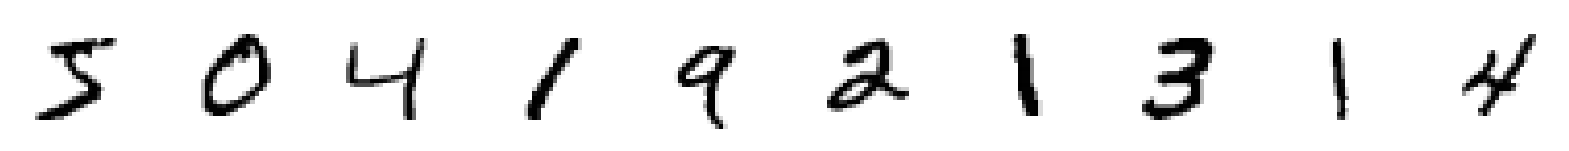

In [15]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

## 2. Build the EBM network <a name="train"></a>

In [16]:
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

In [17]:
if LOAD_MODEL:
    model.load_weights("./models/model.h5")

## 2. Set up a Langevin sampler function <a name="sampler"></a>

In [19]:
# Function to generate samples using Langevin Dynamics
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False,return_energy_scores_per_step=False
):
    imgs_per_step = []
    energy_scores_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
        
        if return_energy_scores_per_step:
            energy_scores_per_step.append(out_score)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0), tf.stack(energy_scores_per_step,axis=0)
    else:
        return inp_imgs

In [20]:
inp_images=tf.random.uniform((128,32,32,1),-1.0,1.0)
images_per_step, scores_per_step = generate_samples(model,inp_images,STEPS,STEP_SIZE,NOISE,True,True)

In [57]:
idx = 1
scores = np.array(tf.stack([score_batch[idx] for score_batch in scores_per_step])).flatten()

<BarContainer object of 60 artists>

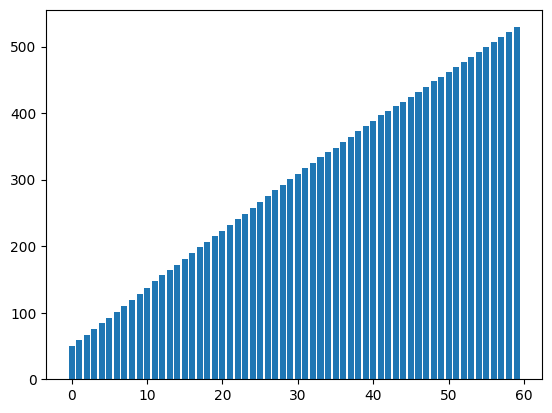

In [58]:
import matplotlib.pyplot as plt

plt.bar(range(len(scores)),scores*10000)

## 3. Set up a buffer to store examples <a name="buffer"></a>

In [15]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [16]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [17]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [18]:
# Compile and train the model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

In [19]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [20]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("./models/model.h5")


save_model_callback = SaveModel()

Epoch 1/60
469/469 [==============================] - ETA: 0s - loss: -0.0398 - reg: 0.0167 - cdiv: -0.0564 - real: 0.2435 - fake: 0.1871
Saved to ./output/generated_img_000.png


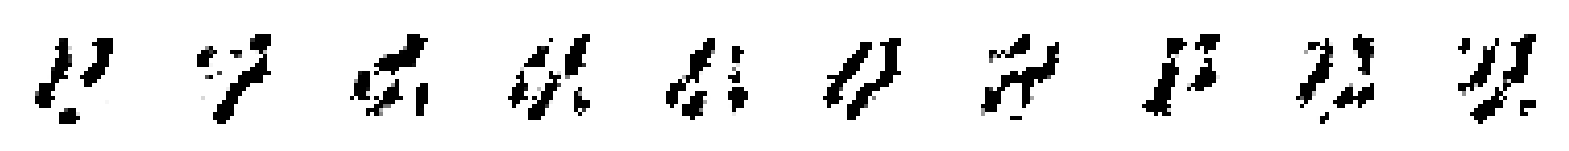


Saved to ./output/example_img_000.png


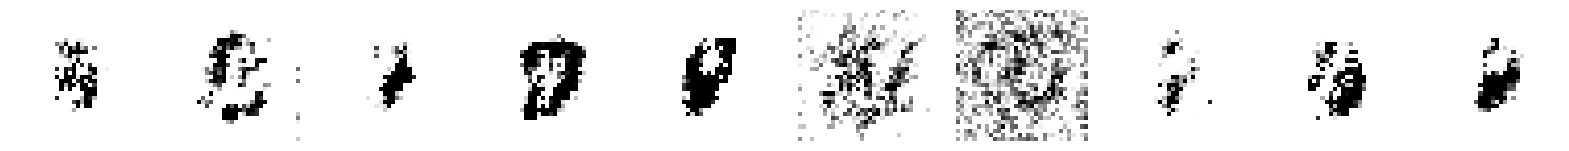

469/469 [==============================] - 1203s 3s/step - loss: -0.0398 - reg: 0.0167 - cdiv: -0.0564 - real: 0.2435 - fake: 0.1871 - val_cdiv: -1.2716 - val_real: -0.0977 - val_fake: -1.3694
Epoch 2/60
469/469 [==============================] - ETA: 0s - loss: -0.0057 - reg: 0.0025 - cdiv: -0.0082 - real: 0.0163 - fake: 0.0081
Saved to ./output/generated_img_001.png


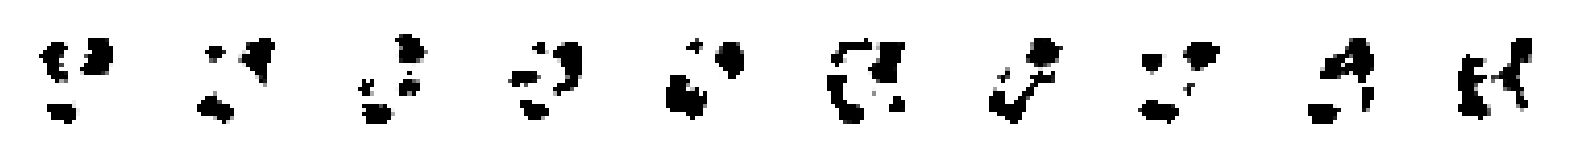


Saved to ./output/example_img_001.png


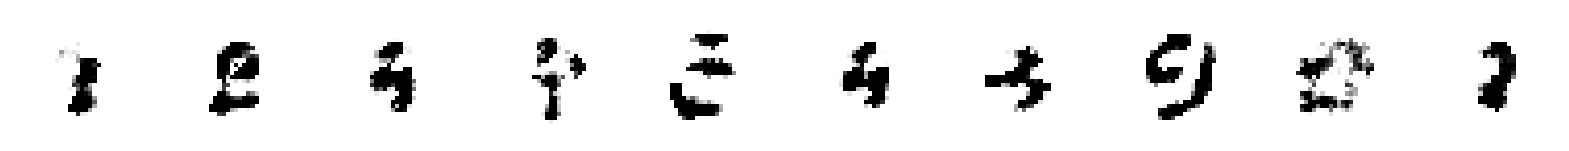

469/469 [==============================] - 1175s 3s/step - loss: -0.0057 - reg: 0.0025 - cdiv: -0.0082 - real: 0.0163 - fake: 0.0081 - val_cdiv: -1.7613 - val_real: -0.0636 - val_fake: -1.8249
Epoch 3/60
469/469 [==============================] - ETA: 0s - loss: -0.0014 - reg: 0.0013 - cdiv: -0.0027 - real: 0.0045 - fake: 0.0018
Saved to ./output/generated_img_002.png


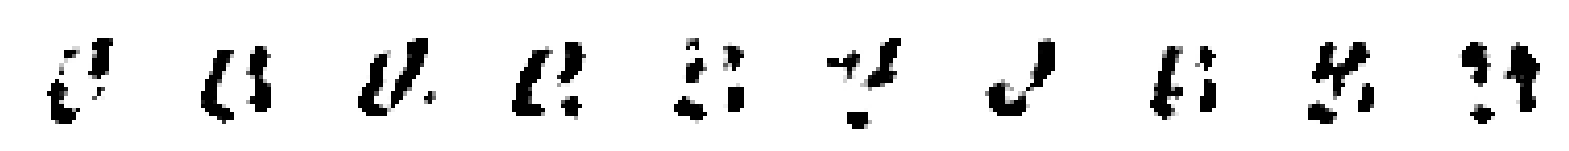


Saved to ./output/example_img_002.png


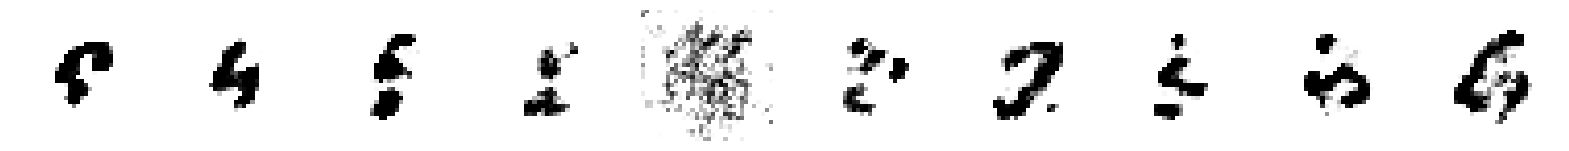

469/469 [==============================] - 1173s 3s/step - loss: -0.0014 - reg: 0.0013 - cdiv: -0.0027 - real: 0.0045 - fake: 0.0018 - val_cdiv: -2.0617 - val_real: -0.0353 - val_fake: -2.0970
Epoch 4/60
469/469 [==============================] - ETA: 0s - loss: -2.4812e-04 - reg: 6.3293e-04 - cdiv: -8.8105e-04 - real: 0.0027 - fake: 0.0018
Saved to ./output/generated_img_003.png


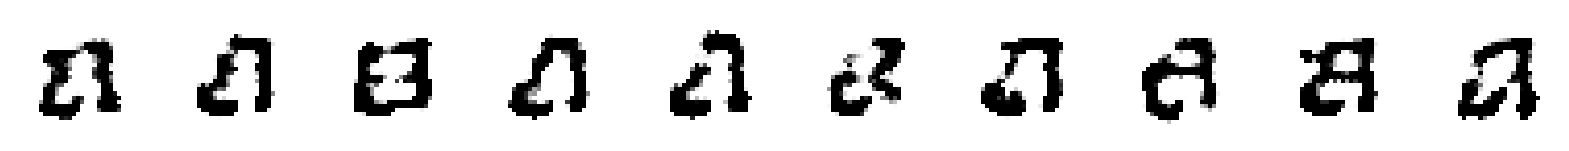


Saved to ./output/example_img_003.png


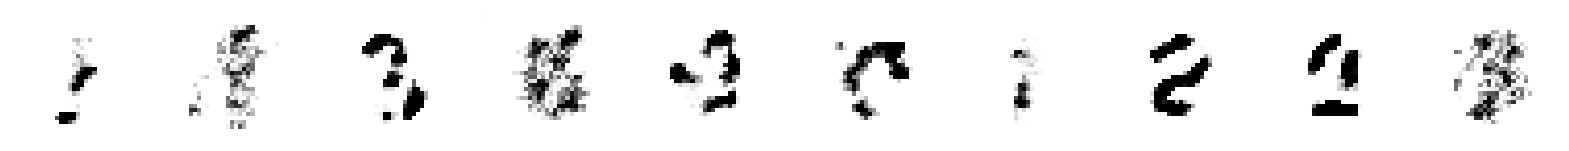

469/469 [==============================] - 1170s 2s/step - loss: -2.4812e-04 - reg: 6.3293e-04 - cdiv: -8.8105e-04 - real: 0.0027 - fake: 0.0018 - val_cdiv: -2.3375 - val_real: -0.0180 - val_fake: -2.3555
Epoch 5/60
469/469 [==============================] - ETA: 0s - loss: 1.9157e-04 - reg: 3.2751e-04 - cdiv: -1.3594e-04 - real: 0.0016 - fake: 0.0015
Saved to ./output/generated_img_004.png


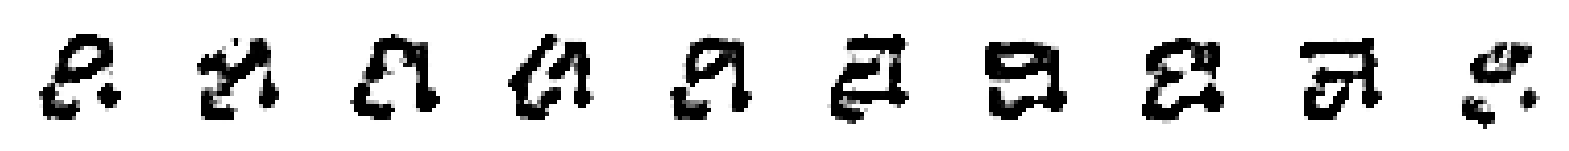


Saved to ./output/example_img_004.png


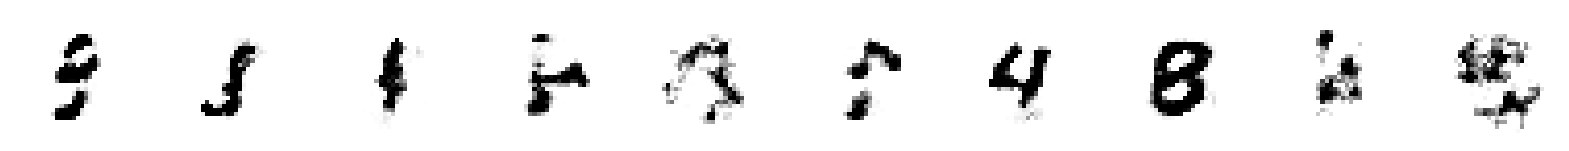

469/469 [==============================] - 1169s 2s/step - loss: 1.9157e-04 - reg: 3.2751e-04 - cdiv: -1.3594e-04 - real: 0.0016 - fake: 0.0015 - val_cdiv: -2.5999 - val_real: -0.0146 - val_fake: -2.6145
Epoch 6/60
469/469 [==============================] - ETA: 0s - loss: -2.9426e-04 - reg: 3.1463e-04 - cdiv: -6.0889e-04 - real: 0.0024 - fake: 0.0018
Saved to ./output/generated_img_005.png


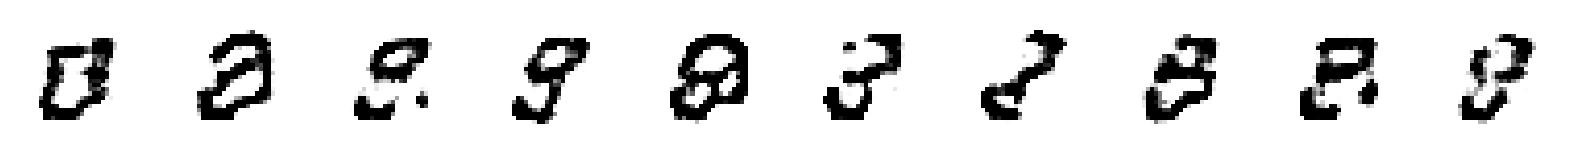


Saved to ./output/example_img_005.png


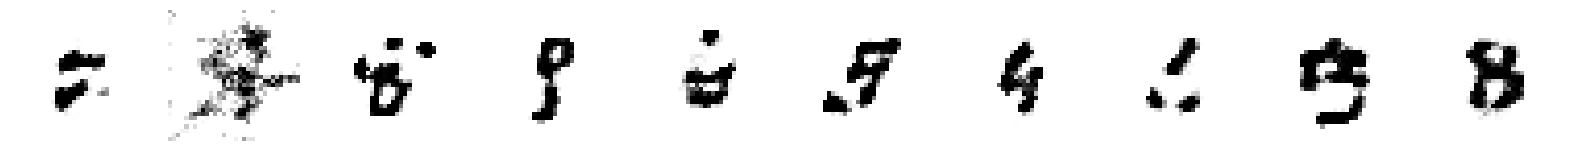

469/469 [==============================] - 1173s 3s/step - loss: -2.9426e-04 - reg: 3.1463e-04 - cdiv: -6.0889e-04 - real: 0.0024 - fake: 0.0018 - val_cdiv: -3.0650 - val_real: 0.0156 - val_fake: -3.0493
Epoch 7/60
469/469 [==============================] - ETA: 0s - loss: -1.5227e-05 - reg: 3.5100e-04 - cdiv: -3.6623e-04 - real: 0.0017 - fake: 0.0013
Saved to ./output/generated_img_006.png


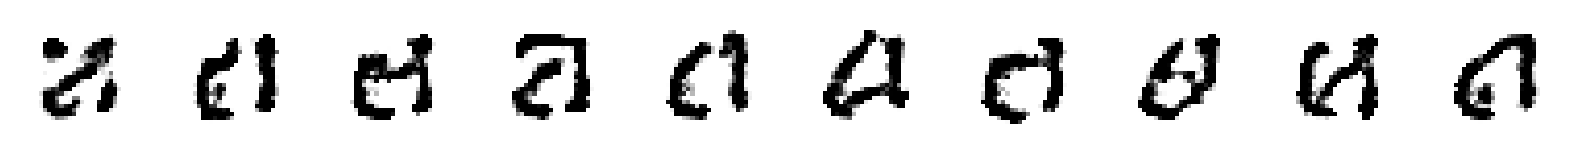


Saved to ./output/example_img_006.png


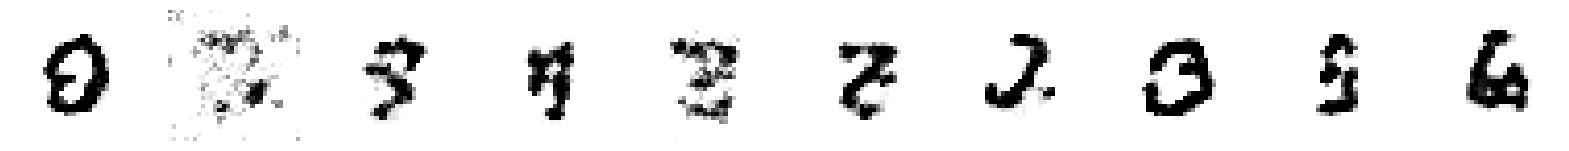

469/469 [==============================] - 1174s 3s/step - loss: -1.5227e-05 - reg: 3.5100e-04 - cdiv: -3.6623e-04 - real: 0.0017 - fake: 0.0013 - val_cdiv: -3.4471 - val_real: 0.0213 - val_fake: -3.4258
Epoch 8/60
469/469 [==============================] - ETA: 0s - loss: 2.1527e-04 - reg: 3.3017e-04 - cdiv: -1.1490e-04 - real: 0.0013 - fake: 0.0012 
Saved to ./output/generated_img_007.png


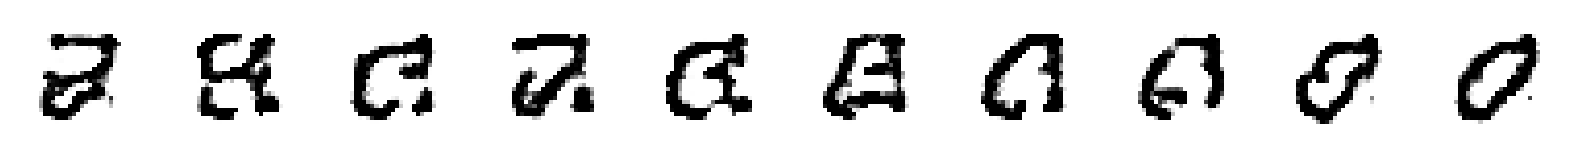


Saved to ./output/example_img_007.png


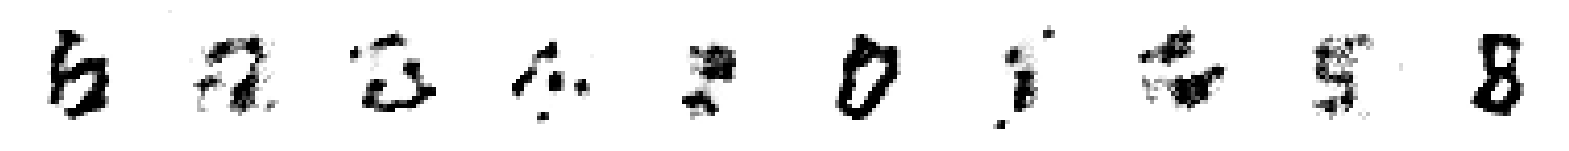

469/469 [==============================] - 1171s 2s/step - loss: 2.1527e-04 - reg: 3.3017e-04 - cdiv: -1.1490e-04 - real: 0.0013 - fake: 0.0012 - val_cdiv: -3.6797 - val_real: 0.0028 - val_fake: -3.6770
Epoch 9/60
469/469 [==============================] - ETA: 0s - loss: -1.9163e-04 - reg: 3.3473e-04 - cdiv: -5.2636e-04 - real: 0.0016 - fake: 0.0011  
Saved to ./output/generated_img_008.png


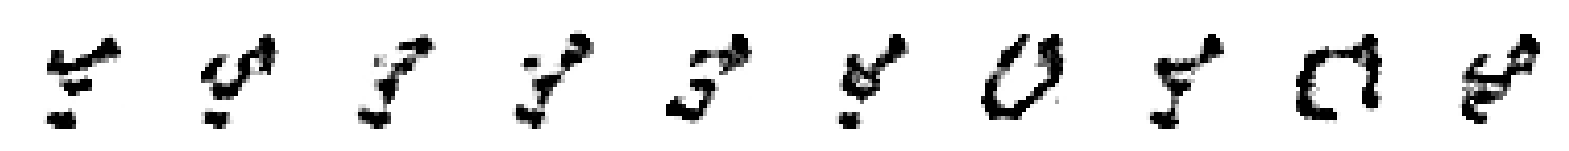


Saved to ./output/example_img_008.png


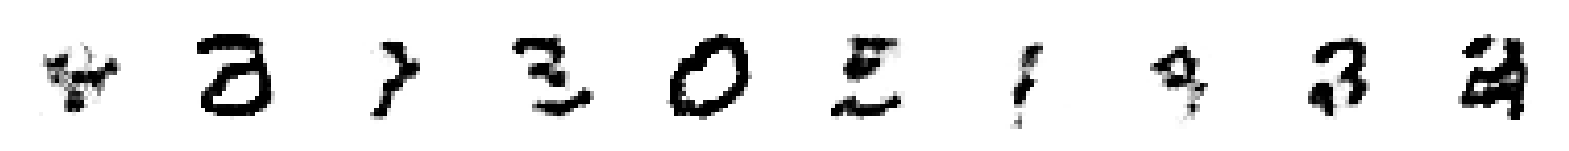

469/469 [==============================] - 1172s 2s/step - loss: -1.9163e-04 - reg: 3.3473e-04 - cdiv: -5.2636e-04 - real: 0.0016 - fake: 0.0011 - val_cdiv: -4.0983 - val_real: 0.0223 - val_fake: -4.0760
Epoch 10/60
469/469 [==============================] - ETA: 0s - loss: -2.1975e-04 - reg: 3.4347e-04 - cdiv: -5.6322e-04 - real: 0.0020 - fake: 0.0014
Saved to ./output/generated_img_009.png


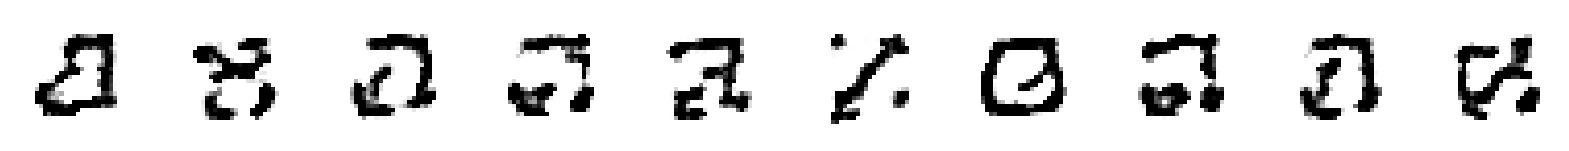


Saved to ./output/example_img_009.png


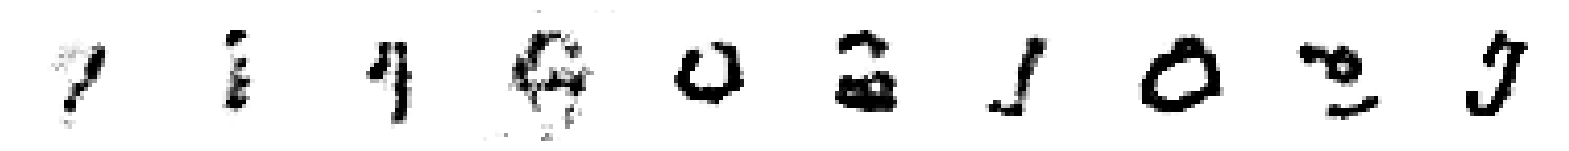

469/469 [==============================] - 1171s 2s/step - loss: -2.1975e-04 - reg: 3.4347e-04 - cdiv: -5.6322e-04 - real: 0.0020 - fake: 0.0014 - val_cdiv: -4.5717 - val_real: 0.0179 - val_fake: -4.5537
Epoch 11/60
469/469 [==============================] - ETA: 0s - loss: 3.7771e-05 - reg: 3.1799e-04 - cdiv: -2.8022e-04 - real: 9.9448e-04 - fake: 7.1426e-04
Saved to ./output/generated_img_010.png


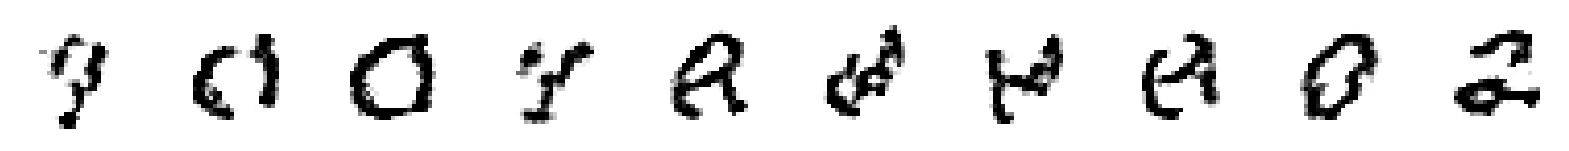


Saved to ./output/example_img_010.png


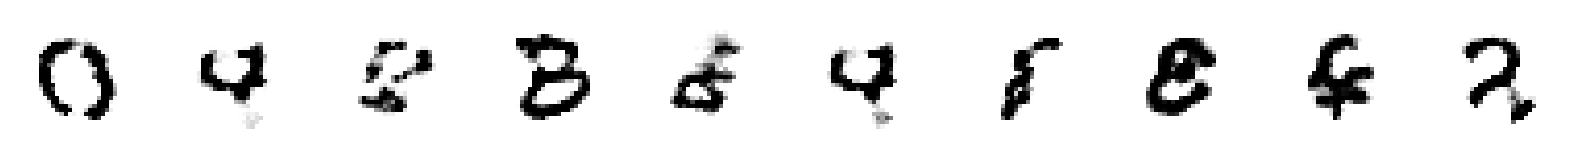

469/469 [==============================] - 1170s 2s/step - loss: 3.7771e-05 - reg: 3.1799e-04 - cdiv: -2.8022e-04 - real: 9.9448e-04 - fake: 7.1426e-04 - val_cdiv: -4.8696 - val_real: 0.0084 - val_fake: -4.8612
Epoch 12/60
469/469 [==============================] - ETA: 0s - loss: -5.4495e-05 - reg: 2.6753e-04 - cdiv: -3.2202e-04 - real: 0.0012 - fake: 8.3981e-04  
Saved to ./output/generated_img_011.png


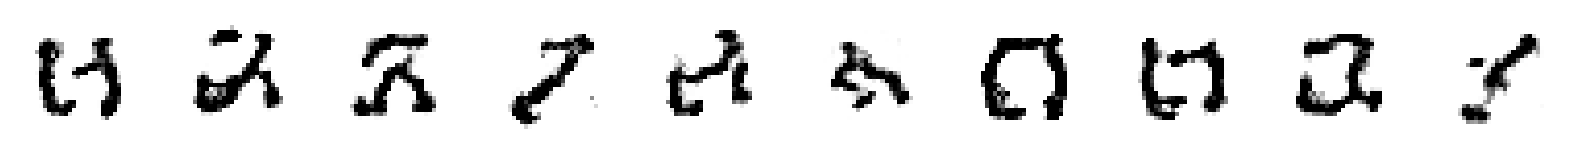


Saved to ./output/example_img_011.png


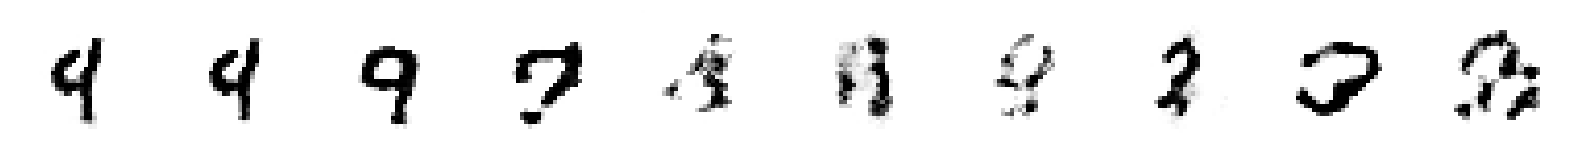

469/469 [==============================] - 1180s 3s/step - loss: -5.4495e-05 - reg: 2.6753e-04 - cdiv: -3.2202e-04 - real: 0.0012 - fake: 8.3981e-04 - val_cdiv: -5.2077 - val_real: 0.0329 - val_fake: -5.1748
Epoch 13/60
469/469 [==============================] - ETA: 0s - loss: -2.5319e-04 - reg: 3.0591e-04 - cdiv: -5.5910e-04 - real: 0.0013 - fake: 7.4532e-04
Saved to ./output/generated_img_012.png


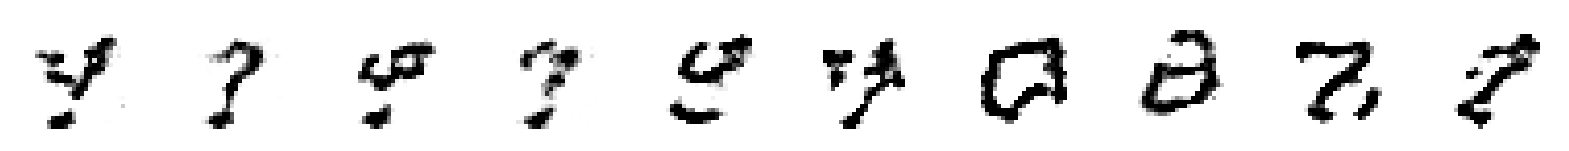


Saved to ./output/example_img_012.png


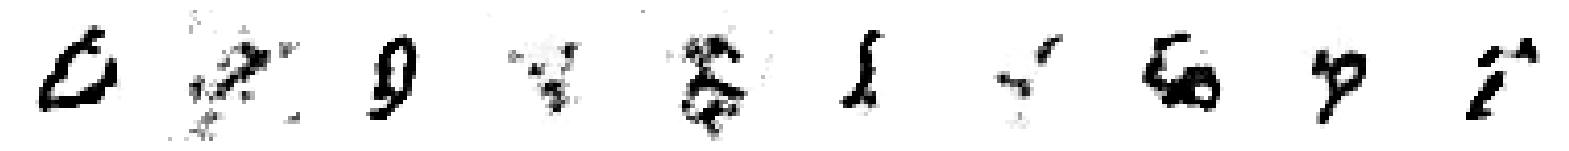

469/469 [==============================] - 1179s 3s/step - loss: -2.5319e-04 - reg: 3.0591e-04 - cdiv: -5.5910e-04 - real: 0.0013 - fake: 7.4532e-04 - val_cdiv: -5.6235 - val_real: 0.0311 - val_fake: -5.5924
Epoch 14/60
469/469 [==============================] - ETA: 0s - loss: 5.4166e-05 - reg: 2.5270e-04 - cdiv: -1.9854e-04 - real: 9.0242e-04 - fake: 7.0388e-04
Saved to ./output/generated_img_013.png


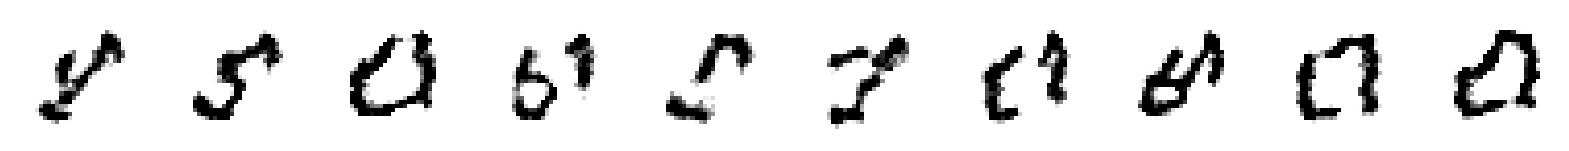


Saved to ./output/example_img_013.png


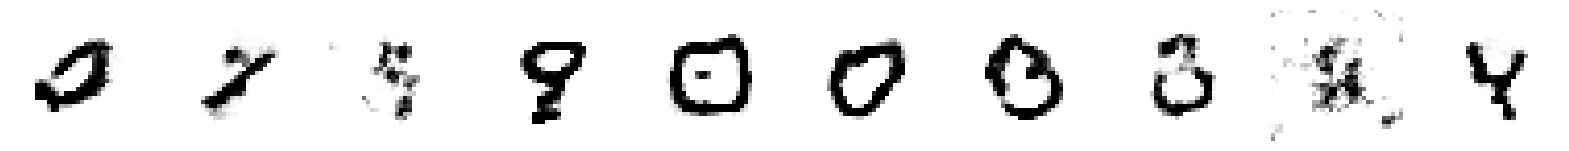

469/469 [==============================] - 1172s 2s/step - loss: 5.4166e-05 - reg: 2.5270e-04 - cdiv: -1.9854e-04 - real: 9.0242e-04 - fake: 7.0388e-04 - val_cdiv: -5.9878 - val_real: 0.0375 - val_fake: -5.9503
Epoch 15/60
469/469 [==============================] - ETA: 0s - loss: 1.1659e-04 - reg: 2.4449e-04 - cdiv: -1.2790e-04 - real: 9.3034e-04 - fake: 8.0244e-04
Saved to ./output/generated_img_014.png


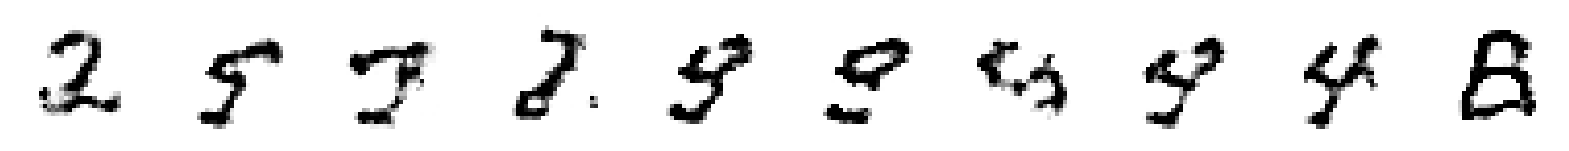


Saved to ./output/example_img_014.png


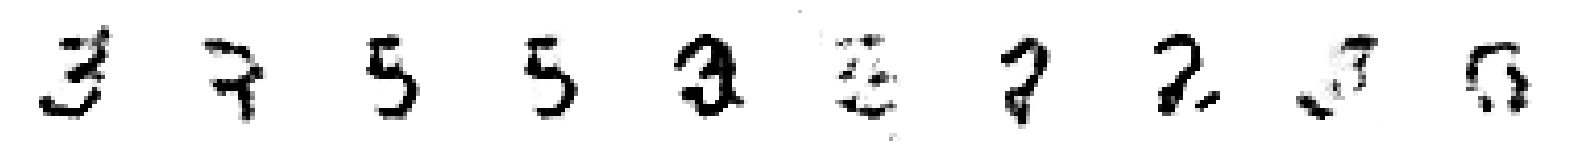

469/469 [==============================] - 1177s 3s/step - loss: 1.1659e-04 - reg: 2.4449e-04 - cdiv: -1.2790e-04 - real: 9.3034e-04 - fake: 8.0244e-04 - val_cdiv: -6.1854 - val_real: 0.0314 - val_fake: -6.1540
Epoch 16/60
469/469 [==============================] - ETA: 0s - loss: -1.6921e-04 - reg: 2.5595e-04 - cdiv: -4.2515e-04 - real: 8.5406e-04 - fake: 4.2891e-04
Saved to ./output/generated_img_015.png


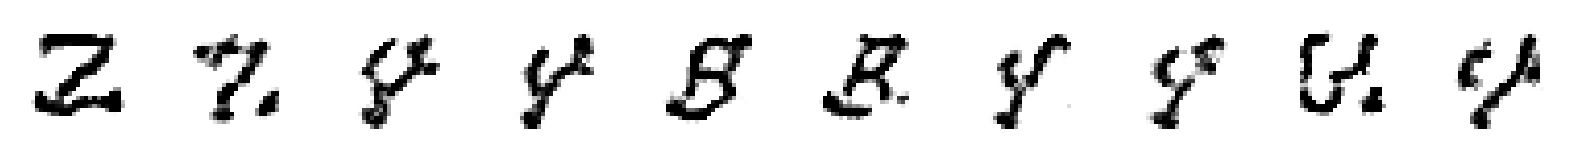


Saved to ./output/example_img_015.png


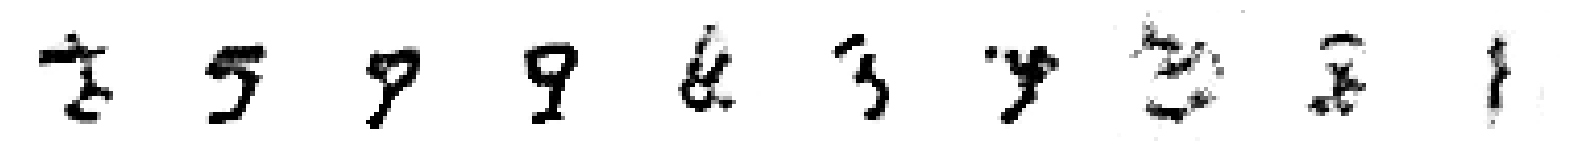

469/469 [==============================] - 1175s 3s/step - loss: -1.6921e-04 - reg: 2.5595e-04 - cdiv: -4.2515e-04 - real: 8.5406e-04 - fake: 4.2891e-04 - val_cdiv: -6.6203 - val_real: 0.0567 - val_fake: -6.5636
Epoch 17/60
469/469 [==============================] - ETA: 0s - loss: 1.6990e-04 - reg: 2.4785e-04 - cdiv: -7.7951e-05 - real: 0.0012 - fake: 0.0011     
Saved to ./output/generated_img_016.png


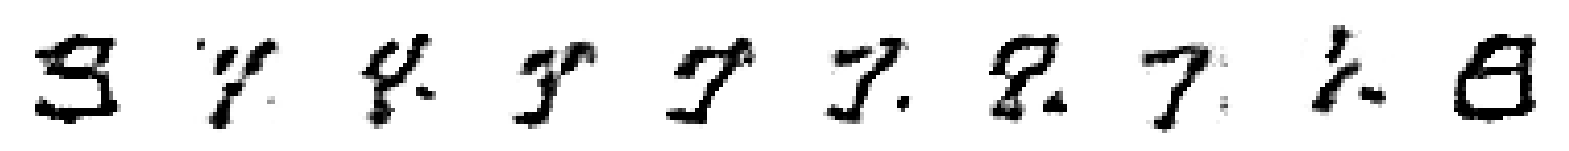


Saved to ./output/example_img_016.png


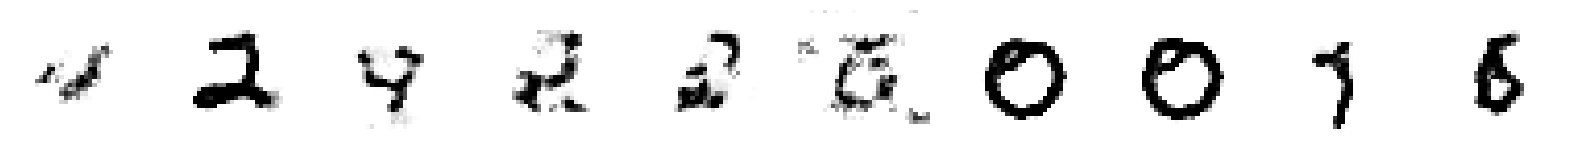

469/469 [==============================] - 1174s 3s/step - loss: 1.6990e-04 - reg: 2.4785e-04 - cdiv: -7.7951e-05 - real: 0.0012 - fake: 0.0011 - val_cdiv: -6.8460 - val_real: 0.0267 - val_fake: -6.8194
Epoch 18/60
469/469 [==============================] - ETA: 0s - loss: 3.1901e-05 - reg: 1.9528e-04 - cdiv: -1.6338e-04 - real: 0.0011 - fake: 9.7522e-04  
Saved to ./output/generated_img_017.png


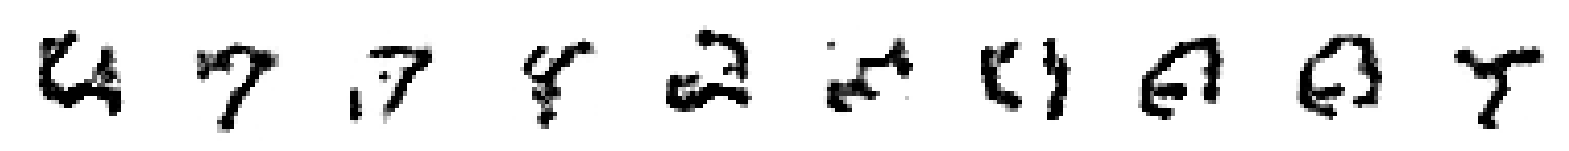


Saved to ./output/example_img_017.png


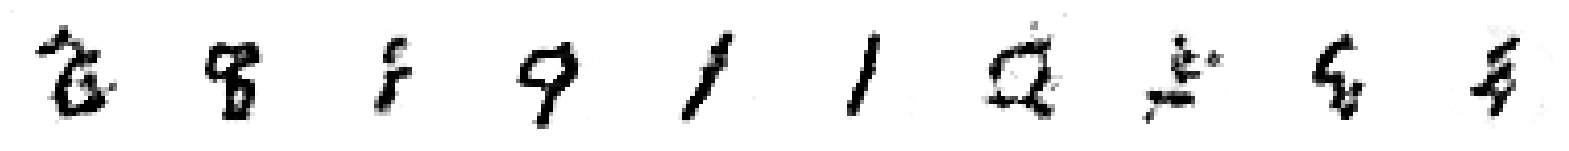

469/469 [==============================] - 1158s 2s/step - loss: 3.1901e-05 - reg: 1.9528e-04 - cdiv: -1.6338e-04 - real: 0.0011 - fake: 9.7522e-04 - val_cdiv: -7.2296 - val_real: 0.0259 - val_fake: -7.2037
Epoch 19/60
469/469 [==============================] - ETA: 0s - loss: 5.9409e-05 - reg: 2.0825e-04 - cdiv: -1.4884e-04 - real: 8.5048e-04 - fake: 7.0164e-04
Saved to ./output/generated_img_018.png


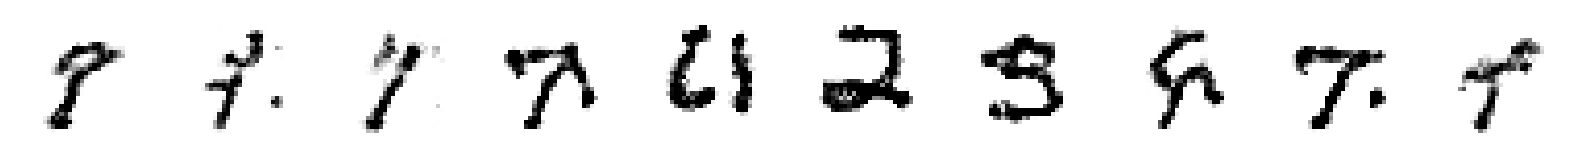


Saved to ./output/example_img_018.png


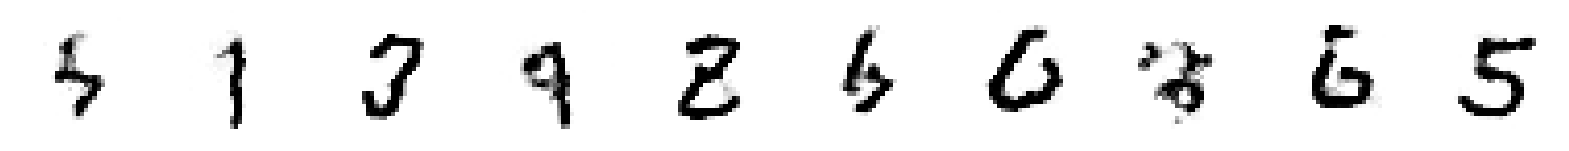

469/469 [==============================] - 1140s 2s/step - loss: 5.9409e-05 - reg: 2.0825e-04 - cdiv: -1.4884e-04 - real: 8.5048e-04 - fake: 7.0164e-04 - val_cdiv: -7.4579 - val_real: 0.0360 - val_fake: -7.4219
Epoch 20/60
469/469 [==============================] - ETA: 0s - loss: -1.2667e-04 - reg: 1.9883e-04 - cdiv: -3.2550e-04 - real: 0.0013 - fake: 0.0010    
Saved to ./output/generated_img_019.png


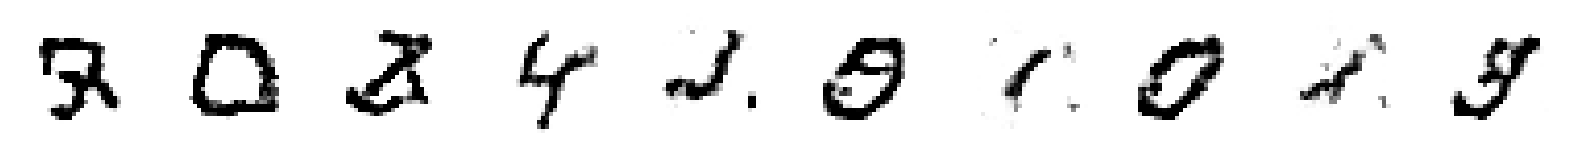


Saved to ./output/example_img_019.png


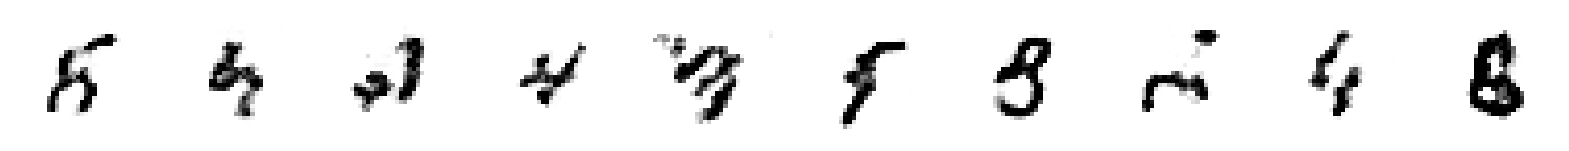

469/469 [==============================] - 1155s 2s/step - loss: -1.2667e-04 - reg: 1.9883e-04 - cdiv: -3.2550e-04 - real: 0.0013 - fake: 0.0010 - val_cdiv: -8.0025 - val_real: 0.0278 - val_fake: -7.9746
Epoch 21/60
469/469 [==============================] - ETA: 0s - loss: 5.8216e-05 - reg: 1.9698e-04 - cdiv: -1.3877e-04 - real: 8.2504e-04 - fake: 6.8627e-04
Saved to ./output/generated_img_020.png


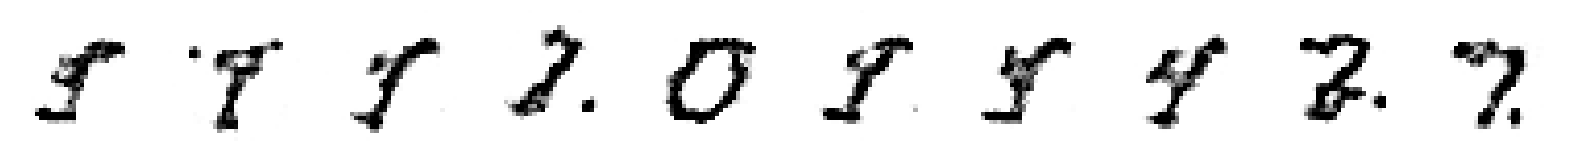


Saved to ./output/example_img_020.png


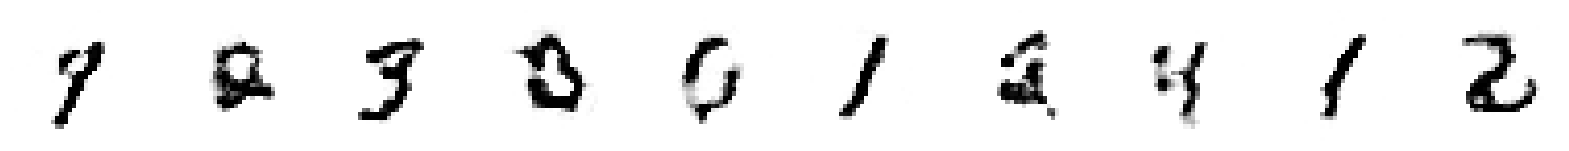

469/469 [==============================] - 1157s 2s/step - loss: 5.8216e-05 - reg: 1.9698e-04 - cdiv: -1.3877e-04 - real: 8.2504e-04 - fake: 6.8627e-04 - val_cdiv: -8.2991 - val_real: 0.0247 - val_fake: -8.2745
Epoch 22/60
469/469 [==============================] - ETA: 0s - loss: 3.5922e-05 - reg: 2.1155e-04 - cdiv: -1.7563e-04 - real: 0.0010 - fake: 8.3774e-04    
Saved to ./output/generated_img_021.png


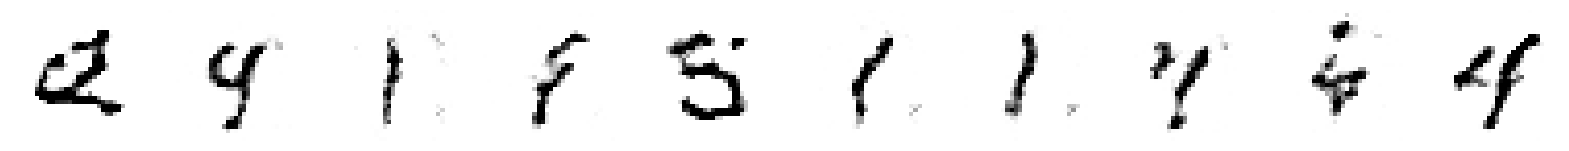


Saved to ./output/example_img_021.png


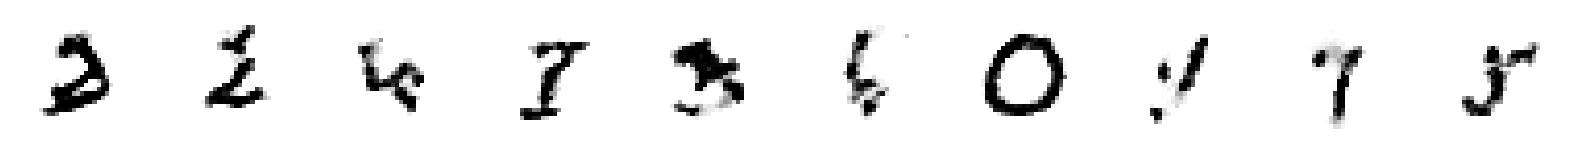

469/469 [==============================] - 1151s 2s/step - loss: 3.5922e-05 - reg: 2.1155e-04 - cdiv: -1.7563e-04 - real: 0.0010 - fake: 8.3774e-04 - val_cdiv: -8.5795 - val_real: 0.0175 - val_fake: -8.5620
Epoch 23/60
469/469 [==============================] - ETA: 0s - loss: -3.7356e-05 - reg: 1.8550e-04 - cdiv: -2.2285e-04 - real: 0.0011 - fake: 8.6468e-04
Saved to ./output/generated_img_022.png


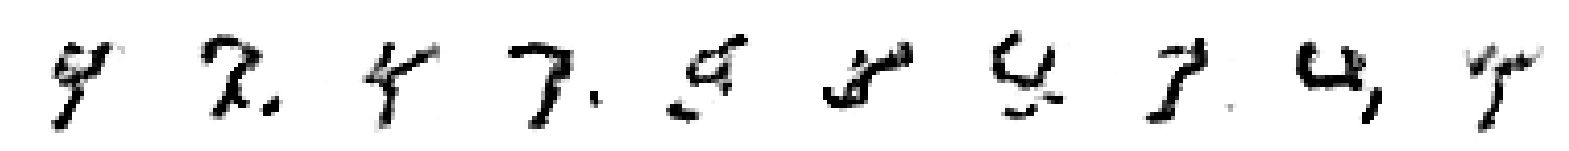


Saved to ./output/example_img_022.png


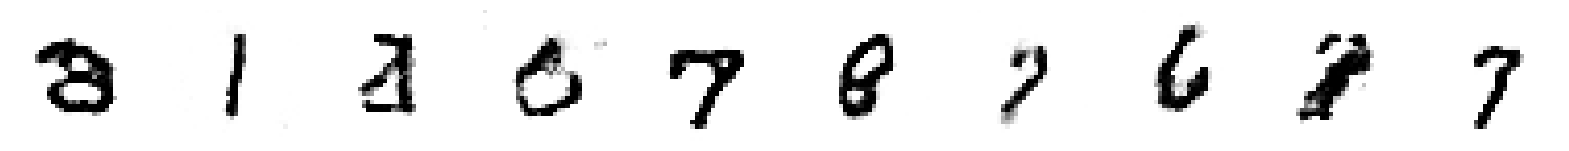

469/469 [==============================] - 1159s 2s/step - loss: -3.7356e-05 - reg: 1.8550e-04 - cdiv: -2.2285e-04 - real: 0.0011 - fake: 8.6468e-04 - val_cdiv: -9.0746 - val_real: 0.0147 - val_fake: -9.0599
Epoch 24/60
469/469 [==============================] - ETA: 0s - loss: 2.4620e-04 - reg: 1.6374e-04 - cdiv: 8.2459e-05 - real: 7.4397e-04 - fake: 8.2643e-04
Saved to ./output/generated_img_023.png


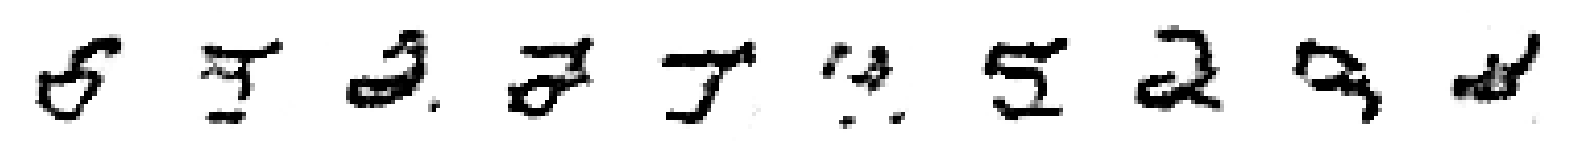


Saved to ./output/example_img_023.png


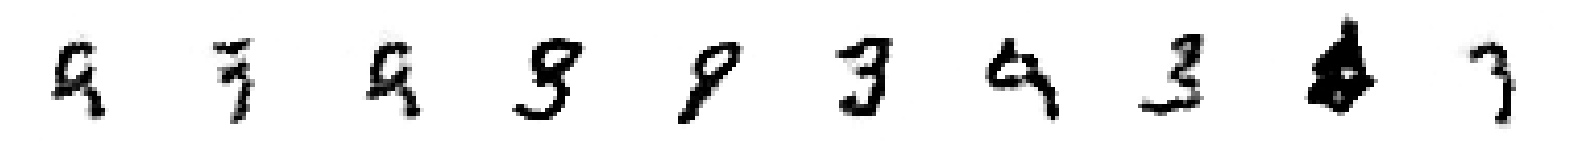

469/469 [==============================] - 1157s 2s/step - loss: 2.4620e-04 - reg: 1.6374e-04 - cdiv: 8.2459e-05 - real: 7.4397e-04 - fake: 8.2643e-04 - val_cdiv: -9.4546 - val_real: 0.0159 - val_fake: -9.4386
Epoch 25/60
469/469 [==============================] - ETA: 0s - loss: 9.4021e-05 - reg: 1.5308e-04 - cdiv: -5.9064e-05 - real: 6.3118e-04 - fake: 5.7212e-04
Saved to ./output/generated_img_024.png


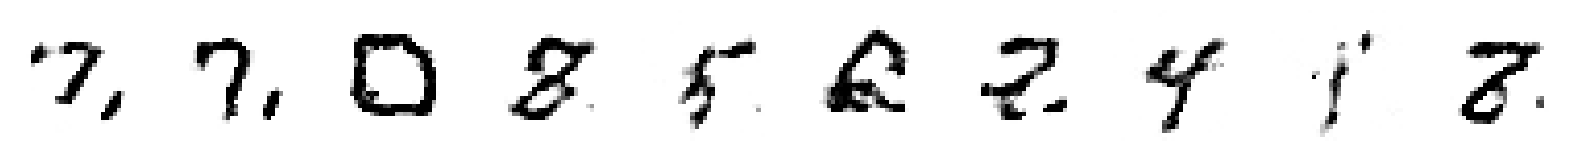


Saved to ./output/example_img_024.png


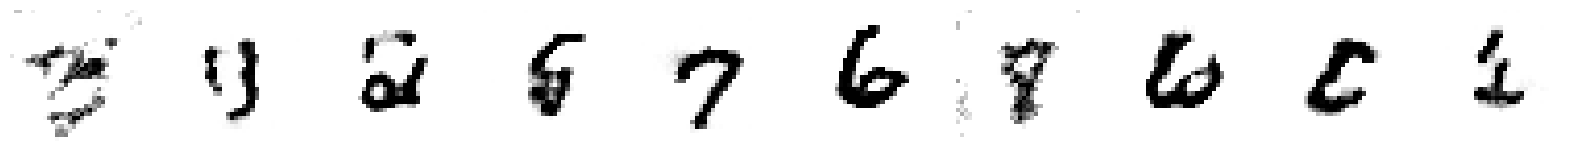

469/469 [==============================] - 1156s 2s/step - loss: 9.4021e-05 - reg: 1.5308e-04 - cdiv: -5.9064e-05 - real: 6.3118e-04 - fake: 5.7212e-04 - val_cdiv: -9.6590 - val_real: 0.0203 - val_fake: -9.6387
Epoch 26/60
469/469 [==============================] - ETA: 0s - loss: 1.2845e-04 - reg: 1.4434e-04 - cdiv: -1.5891e-05 - real: 9.2290e-04 - fake: 9.0701e-04
Saved to ./output/generated_img_025.png


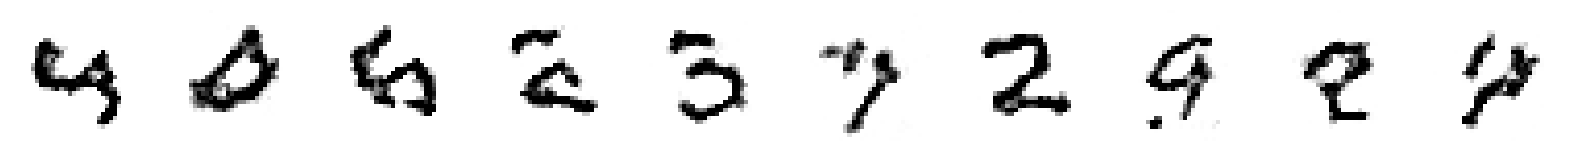


Saved to ./output/example_img_025.png


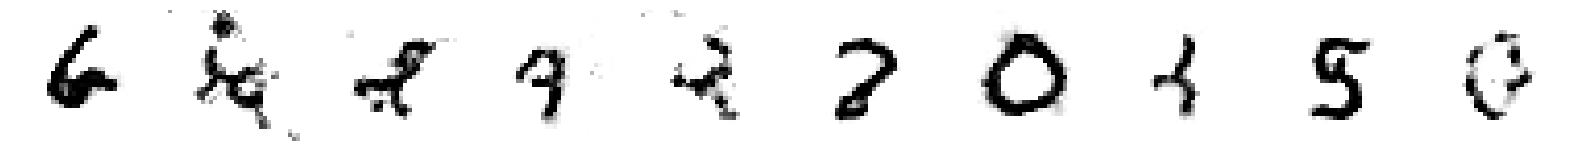

469/469 [==============================] - 1160s 2s/step - loss: 1.2845e-04 - reg: 1.4434e-04 - cdiv: -1.5891e-05 - real: 9.2290e-04 - fake: 9.0701e-04 - val_cdiv: -9.8639 - val_real: 0.0205 - val_fake: -9.8434
Epoch 27/60
469/469 [==============================] - ETA: 0s - loss: 4.9322e-05 - reg: 1.3775e-04 - cdiv: -8.8424e-05 - real: 5.7455e-04 - fake: 4.8612e-04
Saved to ./output/generated_img_026.png


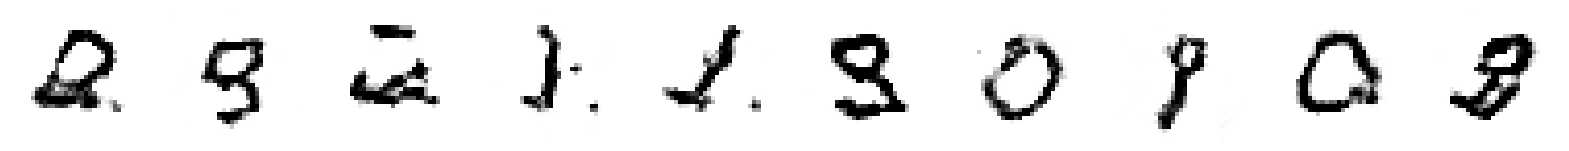


Saved to ./output/example_img_026.png


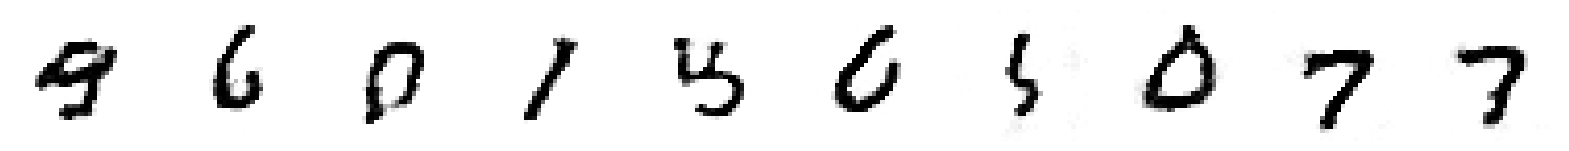

469/469 [==============================] - 1163s 2s/step - loss: 4.9322e-05 - reg: 1.3775e-04 - cdiv: -8.8424e-05 - real: 5.7455e-04 - fake: 4.8612e-04 - val_cdiv: -10.3115 - val_real: 0.0111 - val_fake: -10.3004
Epoch 28/60
469/469 [==============================] - ETA: 0s - loss: 1.3779e-04 - reg: 1.6950e-04 - cdiv: -3.1718e-05 - real: 8.4637e-04 - fake: 8.1465e-04
Saved to ./output/generated_img_027.png


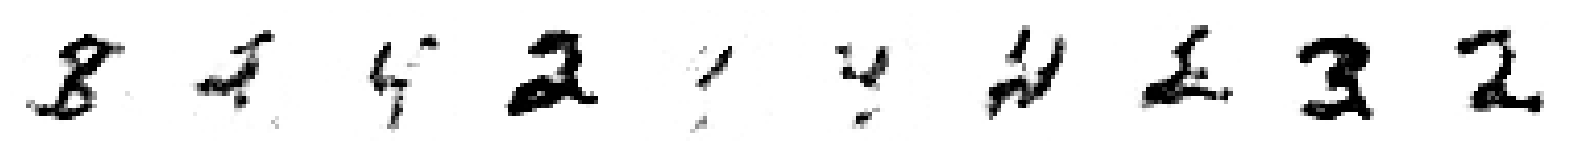


Saved to ./output/example_img_027.png


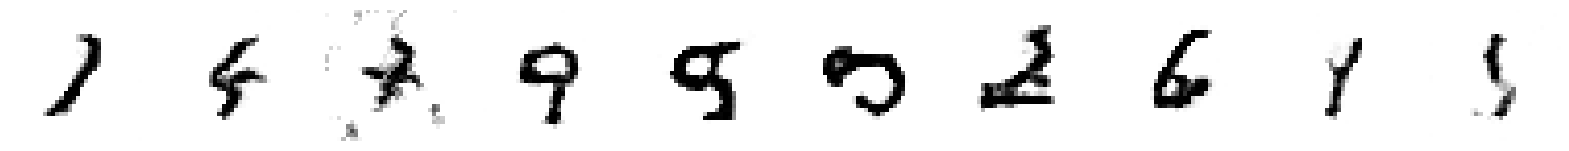

469/469 [==============================] - 1161s 2s/step - loss: 1.3779e-04 - reg: 1.6950e-04 - cdiv: -3.1718e-05 - real: 8.4637e-04 - fake: 8.1465e-04 - val_cdiv: -10.7244 - val_real: 0.0126 - val_fake: -10.7119
Epoch 29/60
469/469 [==============================] - ETA: 0s - loss: -1.7474e-04 - reg: 1.4203e-04 - cdiv: -3.1677e-04 - real: 8.8584e-04 - fake: 5.6907e-04
Saved to ./output/generated_img_028.png


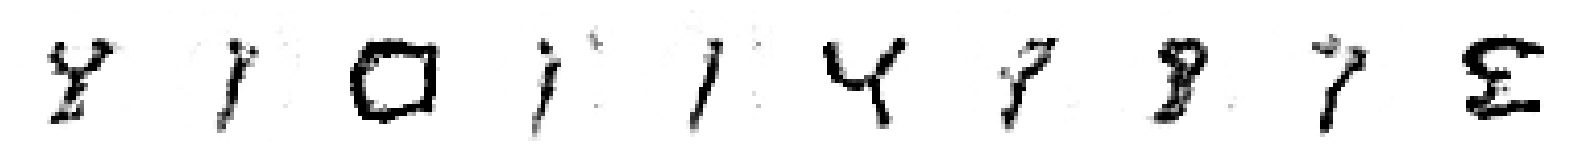


Saved to ./output/example_img_028.png


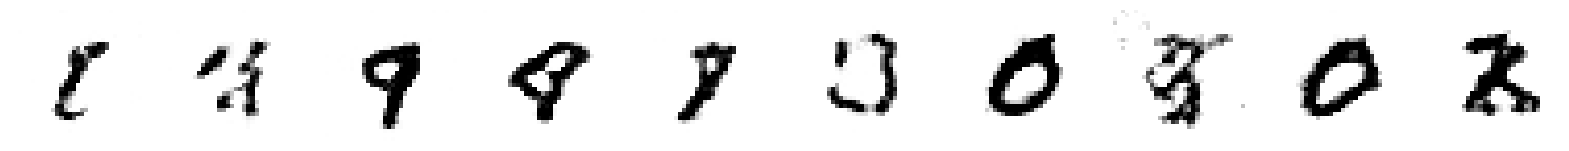

469/469 [==============================] - 1170s 2s/step - loss: -1.7474e-04 - reg: 1.4203e-04 - cdiv: -3.1677e-04 - real: 8.8584e-04 - fake: 5.6907e-04 - val_cdiv: -11.3168 - val_real: 0.0108 - val_fake: -11.3060
Epoch 30/60
469/469 [==============================] - ETA: 0s - loss: 1.2115e-04 - reg: 1.3445e-04 - cdiv: -1.3304e-05 - real: 3.2515e-04 - fake: 3.1185e-04
Saved to ./output/generated_img_029.png


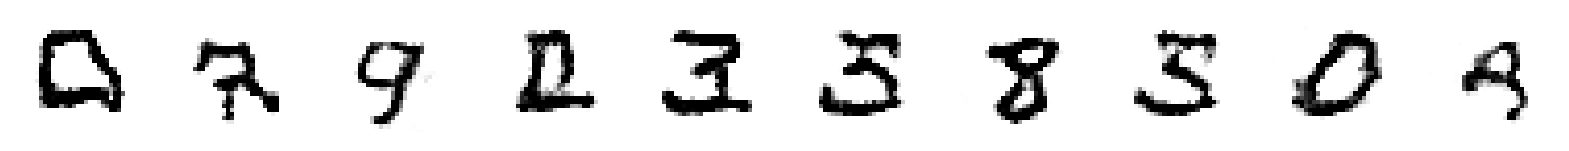


Saved to ./output/example_img_029.png


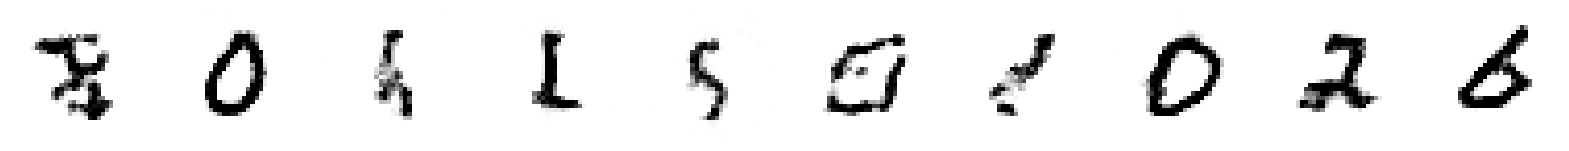

469/469 [==============================] - 1174s 3s/step - loss: 1.2115e-04 - reg: 1.3445e-04 - cdiv: -1.3304e-05 - real: 3.2515e-04 - fake: 3.1185e-04 - val_cdiv: -11.6012 - val_real: 0.0061 - val_fake: -11.5951
Epoch 31/60
469/469 [==============================] - ETA: 0s - loss: 1.8425e-04 - reg: 1.4903e-04 - cdiv: 3.5220e-05 - real: 8.8917e-04 - fake: 9.2439e-04
Saved to ./output/generated_img_030.png


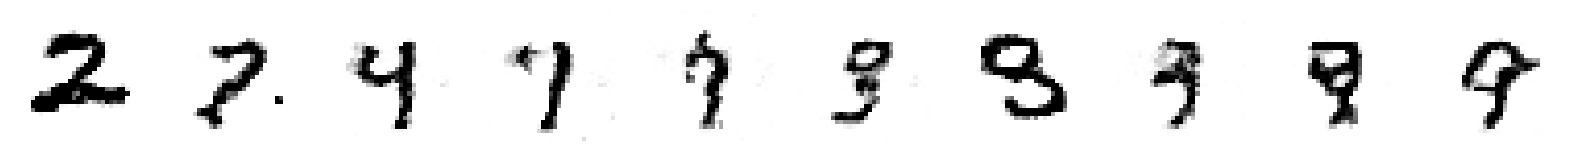


Saved to ./output/example_img_030.png


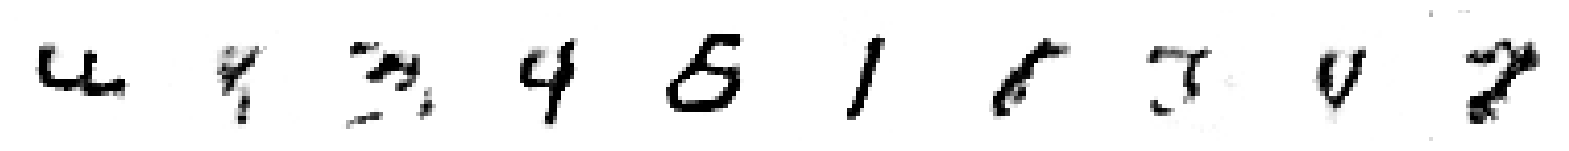

469/469 [==============================] - 1160s 2s/step - loss: 1.8425e-04 - reg: 1.4903e-04 - cdiv: 3.5220e-05 - real: 8.8917e-04 - fake: 9.2439e-04 - val_cdiv: -11.8808 - val_real: 0.0093 - val_fake: -11.8714
Epoch 32/60
469/469 [==============================] - ETA: 0s - loss: 1.8163e-04 - reg: 1.2009e-04 - cdiv: 6.1537e-05 - real: 6.8958e-04 - fake: 7.5112e-04
Saved to ./output/generated_img_031.png


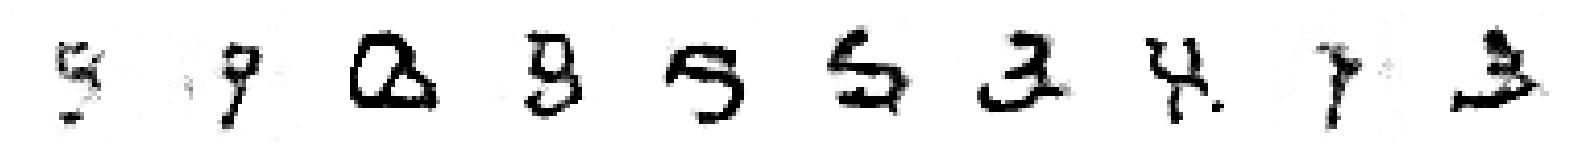


Saved to ./output/example_img_031.png


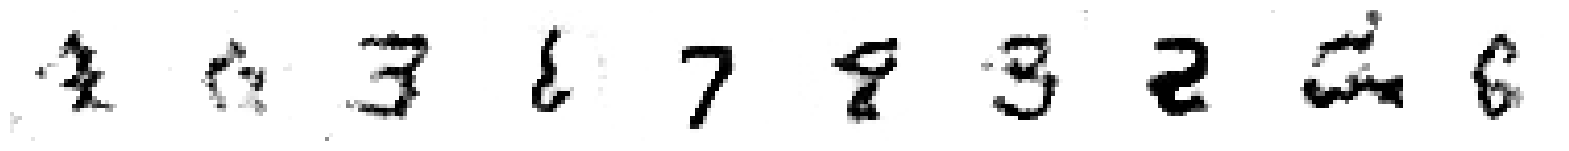

469/469 [==============================] - 1148s 2s/step - loss: 1.8163e-04 - reg: 1.2009e-04 - cdiv: 6.1537e-05 - real: 6.8958e-04 - fake: 7.5112e-04 - val_cdiv: -12.4956 - val_real: 0.0159 - val_fake: -12.4796
Epoch 33/60
469/469 [==============================] - ETA: 0s - loss: -9.5074e-05 - reg: 1.2900e-04 - cdiv: -2.2407e-04 - real: 4.3771e-04 - fake: 2.1364e-04
Saved to ./output/generated_img_032.png


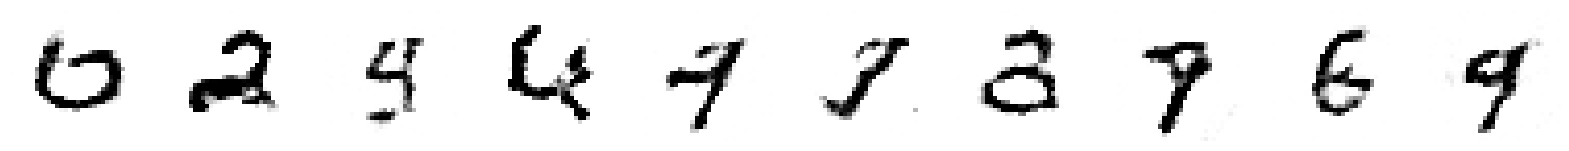


Saved to ./output/example_img_032.png


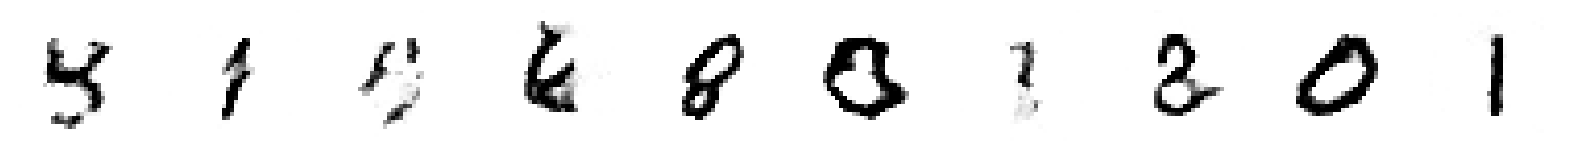

469/469 [==============================] - 1173s 3s/step - loss: -9.5074e-05 - reg: 1.2900e-04 - cdiv: -2.2407e-04 - real: 4.3771e-04 - fake: 2.1364e-04 - val_cdiv: -13.1190 - val_real: 0.0109 - val_fake: -13.1081
Epoch 34/60
469/469 [==============================] - ETA: 0s - loss: 2.8471e-04 - reg: 1.3163e-04 - cdiv: 1.5308e-04 - real: 6.5996e-04 - fake: 8.1304e-04
Saved to ./output/generated_img_033.png


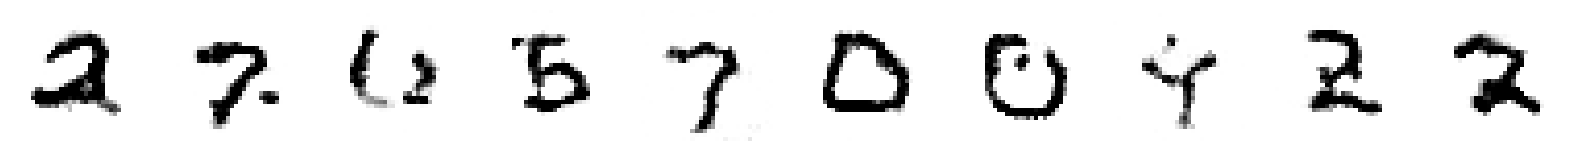


Saved to ./output/example_img_033.png


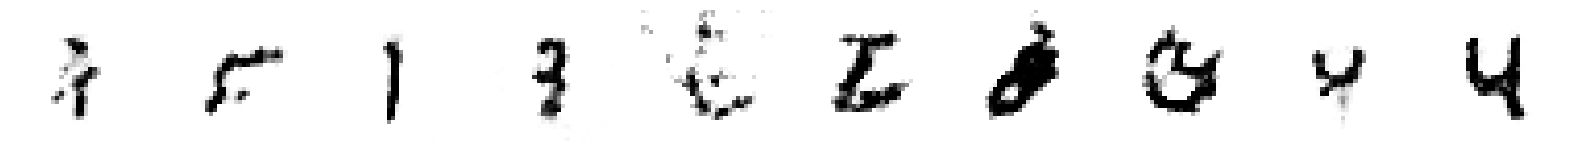

469/469 [==============================] - 1166s 2s/step - loss: 2.8471e-04 - reg: 1.3163e-04 - cdiv: 1.5308e-04 - real: 6.5996e-04 - fake: 8.1304e-04 - val_cdiv: -13.3500 - val_real: 0.0041 - val_fake: -13.3460
Epoch 35/60
469/469 [==============================] - ETA: 0s - loss: 8.3520e-05 - reg: 9.5664e-05 - cdiv: -1.2144e-05 - real: 4.9708e-04 - fake: 4.8493e-04
Saved to ./output/generated_img_034.png


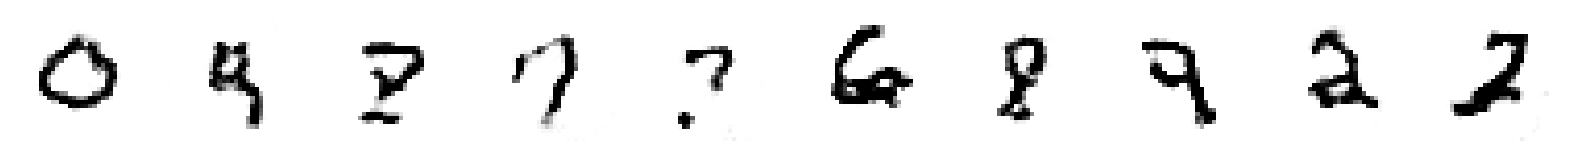


Saved to ./output/example_img_034.png


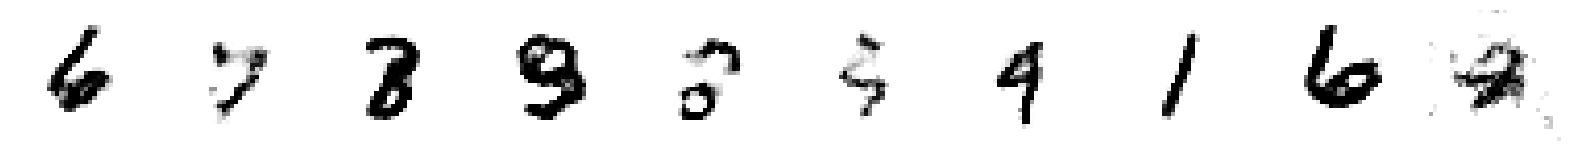

469/469 [==============================] - 1149s 2s/step - loss: 8.3520e-05 - reg: 9.5664e-05 - cdiv: -1.2144e-05 - real: 4.9708e-04 - fake: 4.8493e-04 - val_cdiv: -13.5770 - val_real: -0.0047 - val_fake: -13.5818
Epoch 36/60
469/469 [==============================] - ETA: 0s - loss: -7.3815e-05 - reg: 1.3553e-04 - cdiv: -2.0935e-04 - real: 7.5003e-04 - fake: 5.4068e-04
Saved to ./output/generated_img_035.png


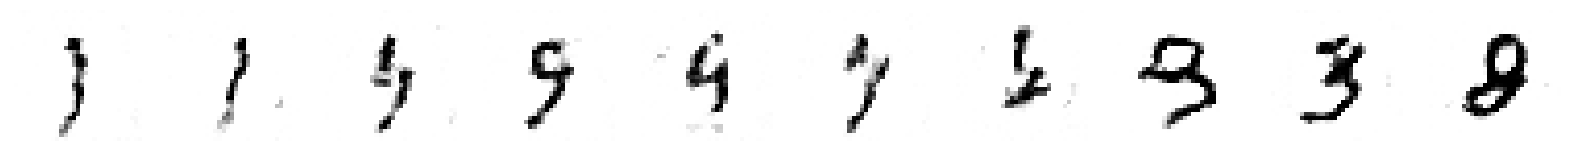


Saved to ./output/example_img_035.png


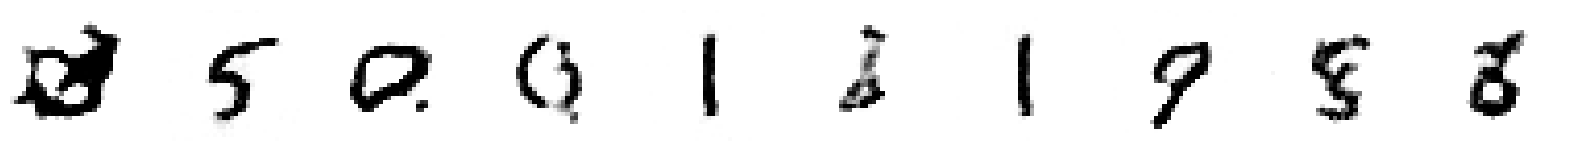

469/469 [==============================] - 1131s 2s/step - loss: -7.3815e-05 - reg: 1.3553e-04 - cdiv: -2.0935e-04 - real: 7.5003e-04 - fake: 5.4068e-04 - val_cdiv: -14.1611 - val_real: 0.0094 - val_fake: -14.1517
Epoch 37/60
469/469 [==============================] - ETA: 0s - loss: 1.3381e-04 - reg: 1.2419e-04 - cdiv: 9.6197e-06 - real: 1.8563e-04 - fake: 1.9524e-04
Saved to ./output/generated_img_036.png


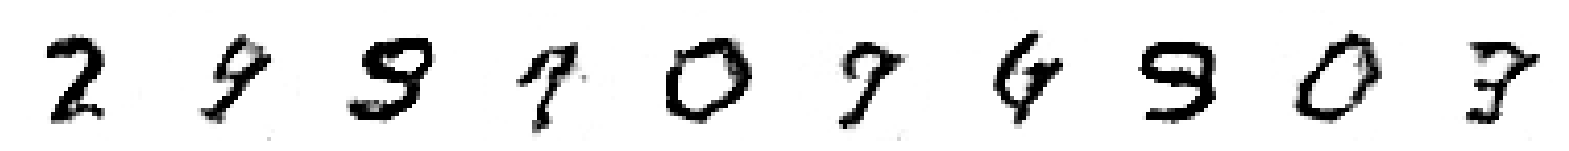


Saved to ./output/example_img_036.png


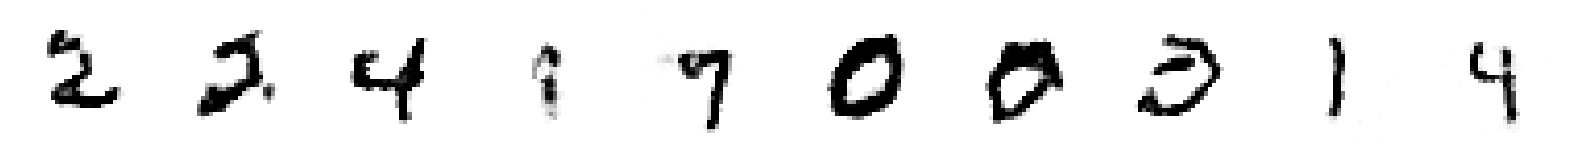

469/469 [==============================] - 1184s 3s/step - loss: 1.3381e-04 - reg: 1.2419e-04 - cdiv: 9.6197e-06 - real: 1.8563e-04 - fake: 1.9524e-04 - val_cdiv: -14.8238 - val_real: 0.0019 - val_fake: -14.8219
Epoch 38/60
469/469 [==============================] - ETA: 0s - loss: 2.7863e-04 - reg: 9.9130e-05 - cdiv: 1.7950e-04 - real: 4.7075e-04 - fake: 6.5025e-04
Saved to ./output/generated_img_037.png


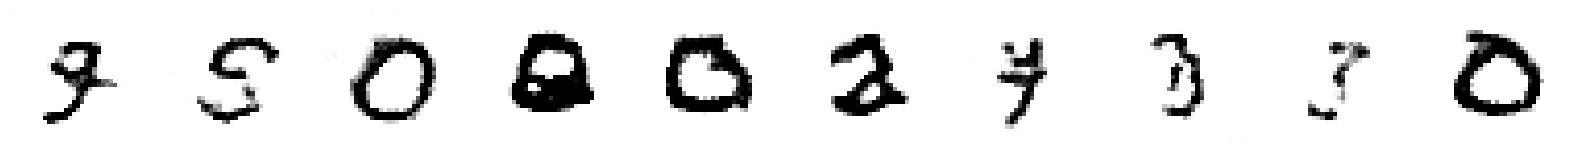


Saved to ./output/example_img_037.png


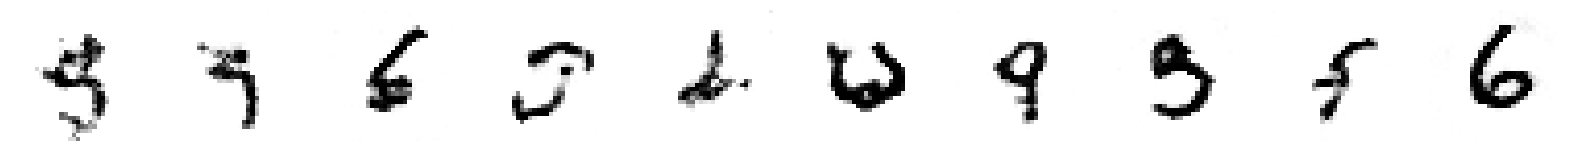

469/469 [==============================] - 1161s 2s/step - loss: 2.7863e-04 - reg: 9.9130e-05 - cdiv: 1.7950e-04 - real: 4.7075e-04 - fake: 6.5025e-04 - val_cdiv: -15.0011 - val_real: -6.9487e-04 - val_fake: -15.0018
Epoch 39/60
469/469 [==============================] - ETA: 0s - loss: -7.7860e-05 - reg: 9.8303e-05 - cdiv: -1.7616e-04 - real: 4.6441e-04 - fake: 2.8825e-04
Saved to ./output/generated_img_038.png


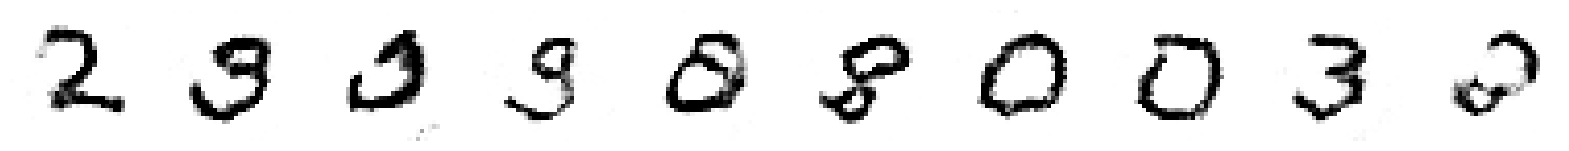


Saved to ./output/example_img_038.png


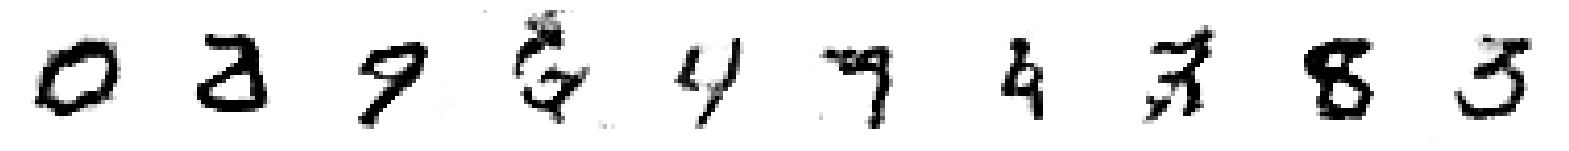

469/469 [==============================] - 1165s 2s/step - loss: -7.7860e-05 - reg: 9.8303e-05 - cdiv: -1.7616e-04 - real: 4.6441e-04 - fake: 2.8825e-04 - val_cdiv: -15.7046 - val_real: 0.0056 - val_fake: -15.6990
Epoch 40/60
469/469 [==============================] - ETA: 0s - loss: 1.0520e-04 - reg: 9.5421e-05 - cdiv: 9.7765e-06 - real: 5.7286e-04 - fake: 5.8264e-04
Saved to ./output/generated_img_039.png


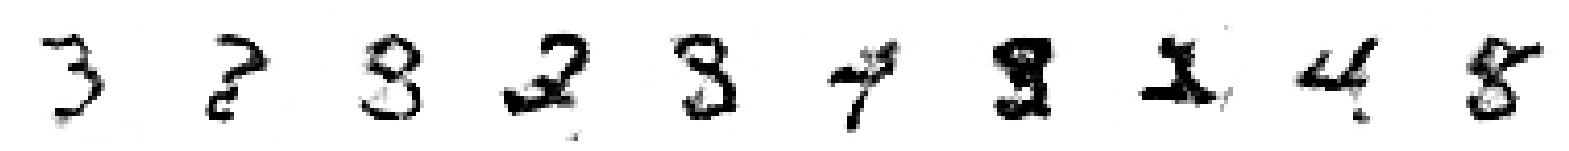


Saved to ./output/example_img_039.png


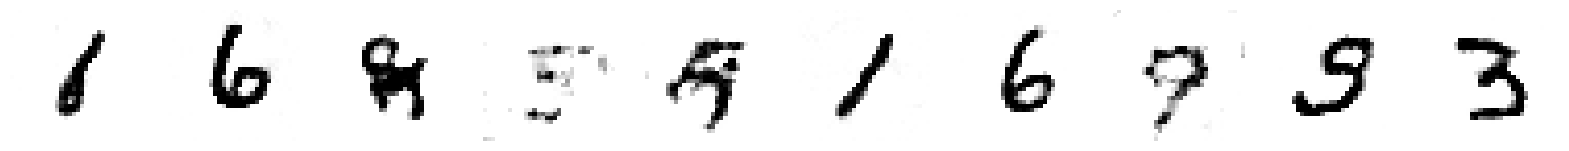

469/469 [==============================] - 1178s 3s/step - loss: 1.0520e-04 - reg: 9.5421e-05 - cdiv: 9.7765e-06 - real: 5.7286e-04 - fake: 5.8264e-04 - val_cdiv: -16.1911 - val_real: 0.0032 - val_fake: -16.1879
Epoch 41/60
469/469 [==============================] - ETA: 0s - loss: 1.9408e-04 - reg: 9.8955e-05 - cdiv: 9.5120e-05 - real: 1.5392e-04 - fake: 2.4904e-04
Saved to ./output/generated_img_040.png


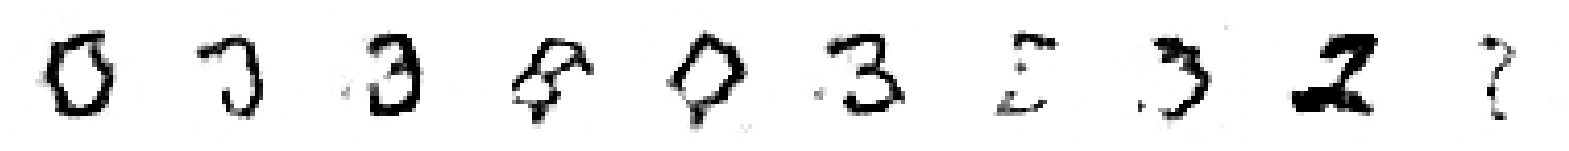


Saved to ./output/example_img_040.png


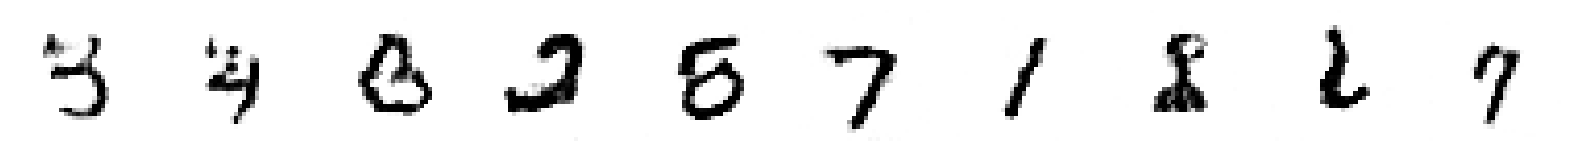

469/469 [==============================] - 1173s 3s/step - loss: 1.9408e-04 - reg: 9.8955e-05 - cdiv: 9.5120e-05 - real: 1.5392e-04 - fake: 2.4904e-04 - val_cdiv: -16.4072 - val_real: 0.0046 - val_fake: -16.4026
Epoch 42/60
469/469 [==============================] - ETA: 0s - loss: -1.2626e-04 - reg: 1.1023e-04 - cdiv: -2.3648e-04 - real: 6.8166e-04 - fake: 4.4518e-04
Saved to ./output/generated_img_041.png


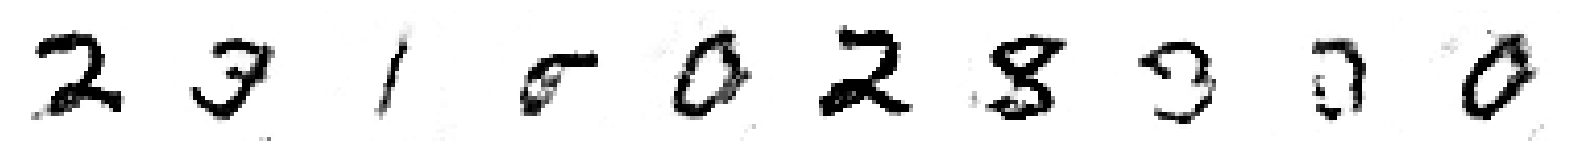


Saved to ./output/example_img_041.png


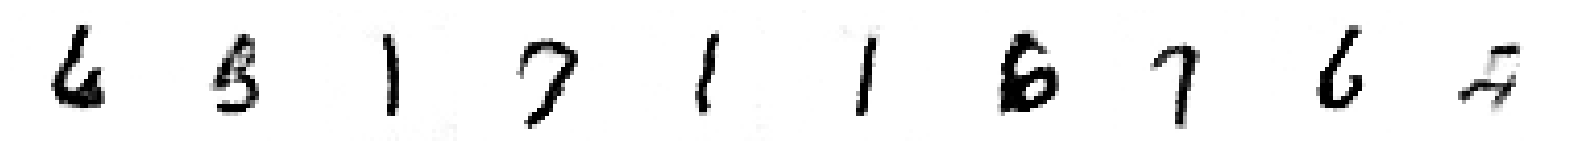

469/469 [==============================] - 1169s 2s/step - loss: -1.2626e-04 - reg: 1.1023e-04 - cdiv: -2.3648e-04 - real: 6.8166e-04 - fake: 4.4518e-04 - val_cdiv: -16.8198 - val_real: -1.9386e-04 - val_fake: -16.8200
Epoch 43/60
469/469 [==============================] - ETA: 0s - loss: 2.4156e-04 - reg: 1.2193e-04 - cdiv: 1.1963e-04 - real: 2.7431e-04 - fake: 3.9394e-04
Saved to ./output/generated_img_042.png


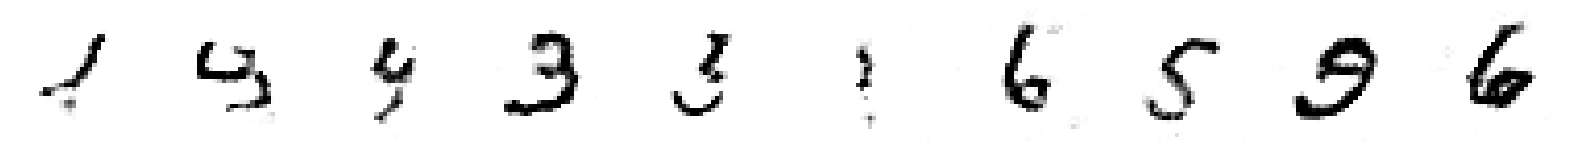


Saved to ./output/example_img_042.png


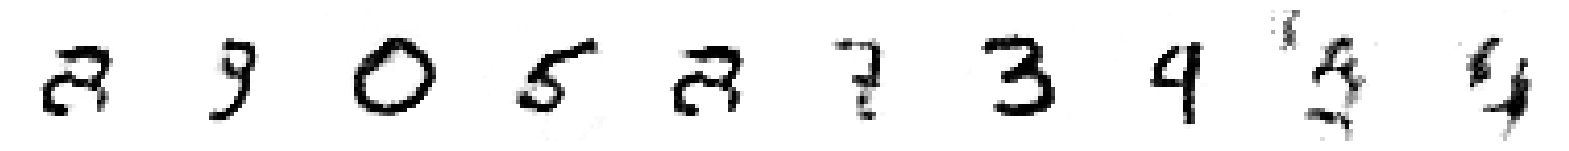

469/469 [==============================] - 1181s 3s/step - loss: 2.4156e-04 - reg: 1.2193e-04 - cdiv: 1.1963e-04 - real: 2.7431e-04 - fake: 3.9394e-04 - val_cdiv: -17.2985 - val_real: -0.0023 - val_fake: -17.3008
Epoch 44/60
469/469 [==============================] - ETA: 0s - loss: 5.6074e-06 - reg: 1.0178e-04 - cdiv: -9.6171e-05 - real: -3.6746e-06 - fake: -9.9846e-05
Saved to ./output/generated_img_043.png


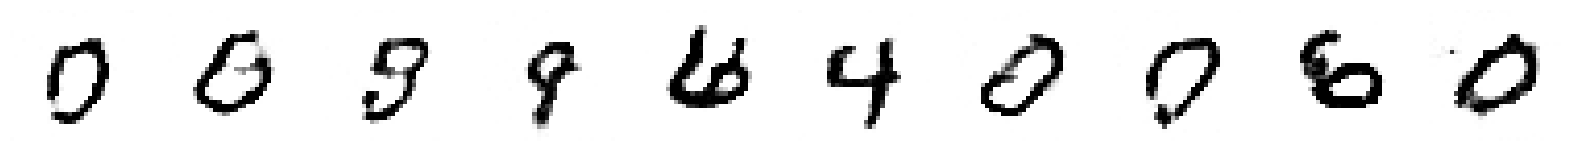


Saved to ./output/example_img_043.png


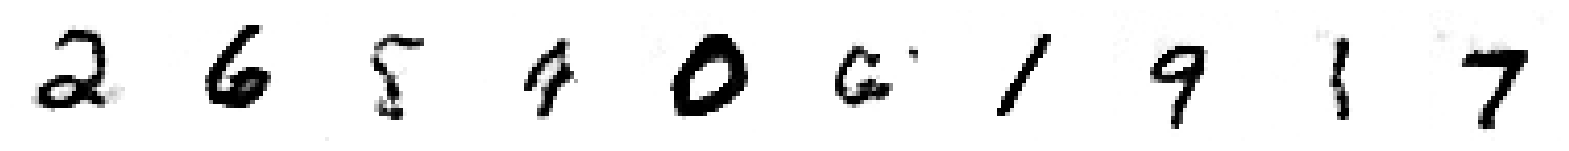

469/469 [==============================] - 1182s 3s/step - loss: 5.6074e-06 - reg: 1.0178e-04 - cdiv: -9.6171e-05 - real: -3.6746e-06 - fake: -9.9846e-05 - val_cdiv: -17.2427 - val_real: -4.4750e-05 - val_fake: -17.2428
Epoch 45/60
469/469 [==============================] - ETA: 0s - loss: 1.1607e-04 - reg: 1.0265e-04 - cdiv: 1.3422e-05 - real: 3.7188e-04 - fake: 3.8530e-04
Saved to ./output/generated_img_044.png


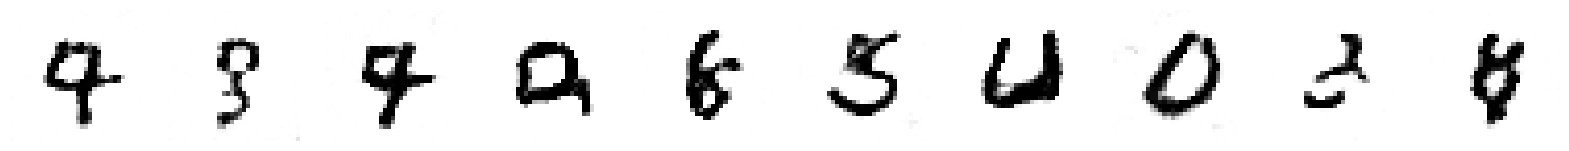


Saved to ./output/example_img_044.png


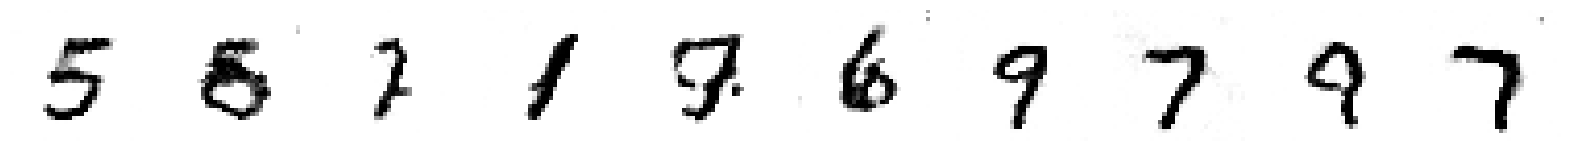

469/469 [==============================] - 1170s 2s/step - loss: 1.1607e-04 - reg: 1.0265e-04 - cdiv: 1.3422e-05 - real: 3.7188e-04 - fake: 3.8530e-04 - val_cdiv: -17.8874 - val_real: 0.0034 - val_fake: -17.8840
Epoch 46/60
469/469 [==============================] - ETA: 0s - loss: 2.3778e-04 - reg: 1.1075e-04 - cdiv: 1.2703e-04 - real: 1.8378e-04 - fake: 3.1081e-04
Saved to ./output/generated_img_045.png


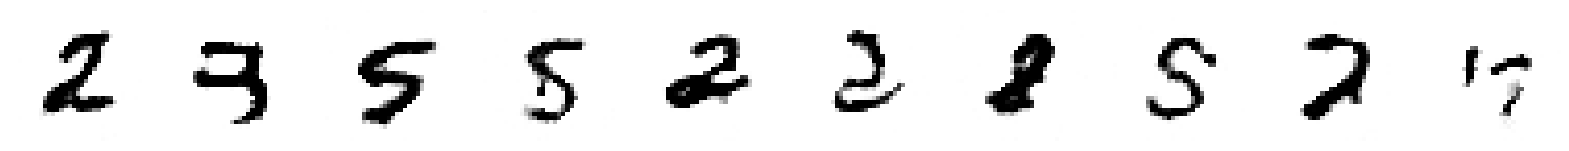


Saved to ./output/example_img_045.png


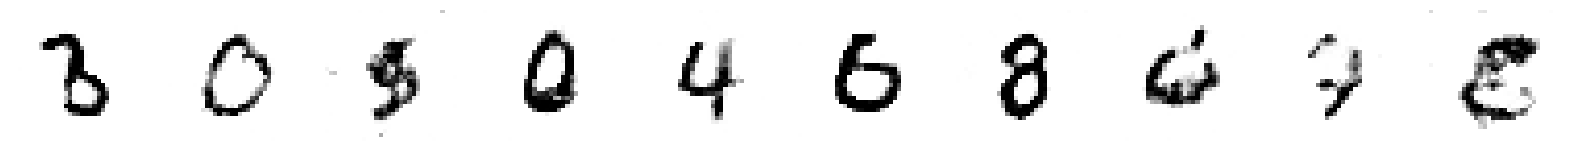

469/469 [==============================] - 1179s 3s/step - loss: 2.3778e-04 - reg: 1.1075e-04 - cdiv: 1.2703e-04 - real: 1.8378e-04 - fake: 3.1081e-04 - val_cdiv: -17.7918 - val_real: -0.0060 - val_fake: -17.7978
Epoch 47/60
469/469 [==============================] - ETA: 0s - loss: 1.5085e-04 - reg: 9.4416e-05 - cdiv: 5.6433e-05 - real: 4.6081e-04 - fake: 5.1724e-04
Saved to ./output/generated_img_046.png


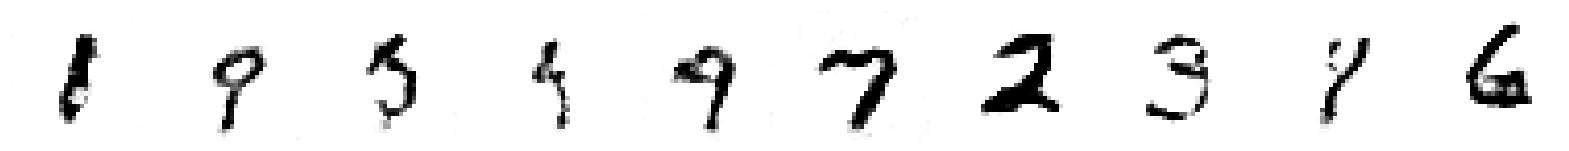


Saved to ./output/example_img_046.png


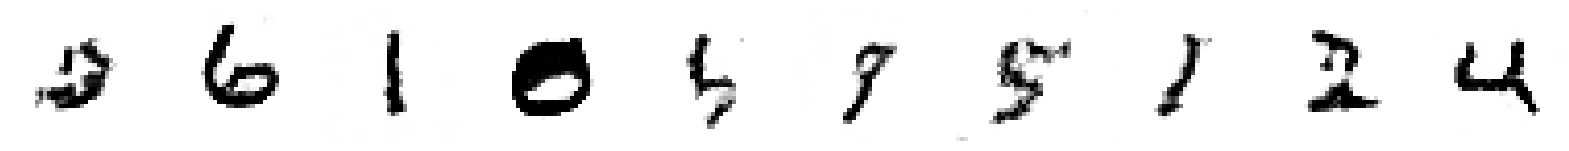

469/469 [==============================] - 1161s 2s/step - loss: 1.5085e-04 - reg: 9.4416e-05 - cdiv: 5.6433e-05 - real: 4.6081e-04 - fake: 5.1724e-04 - val_cdiv: -17.8881 - val_real: -0.0048 - val_fake: -17.8928
Epoch 48/60
469/469 [==============================] - ETA: 0s - loss: 1.5130e-04 - reg: 1.1514e-04 - cdiv: 3.6160e-05 - real: 2.6953e-04 - fake: 3.0569e-04
Saved to ./output/generated_img_047.png


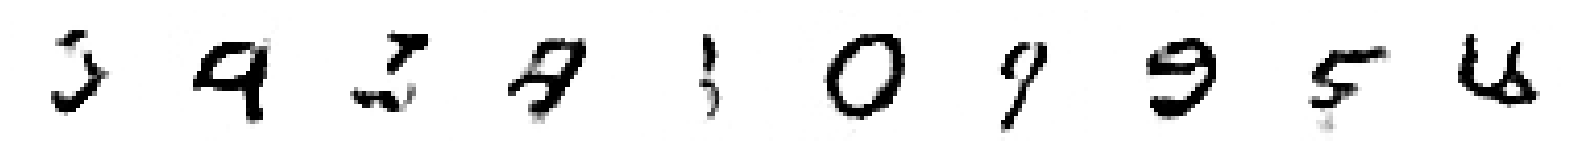


Saved to ./output/example_img_047.png


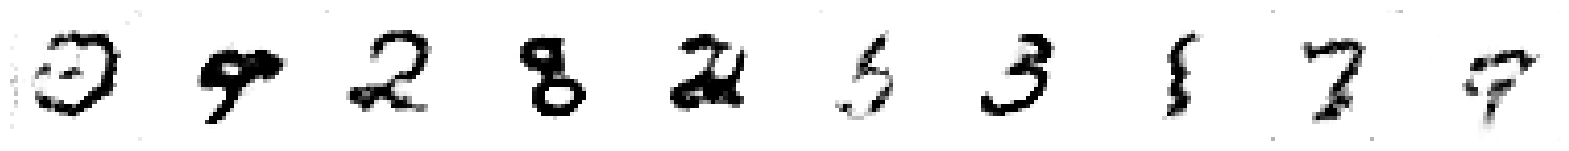

469/469 [==============================] - 1167s 2s/step - loss: 1.5130e-04 - reg: 1.1514e-04 - cdiv: 3.6160e-05 - real: 2.6953e-04 - fake: 3.0569e-04 - val_cdiv: -18.2385 - val_real: -0.0050 - val_fake: -18.2435
Epoch 49/60
469/469 [==============================] - ETA: 0s - loss: 1.1092e-04 - reg: 1.0976e-04 - cdiv: 1.1583e-06 - real: 1.2095e-04 - fake: 1.2211e-04 
Saved to ./output/generated_img_048.png


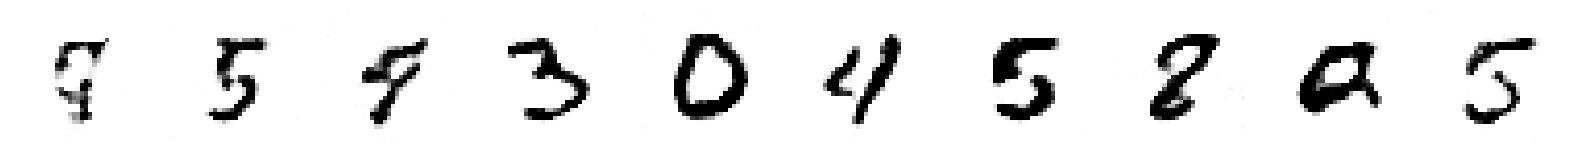


Saved to ./output/example_img_048.png


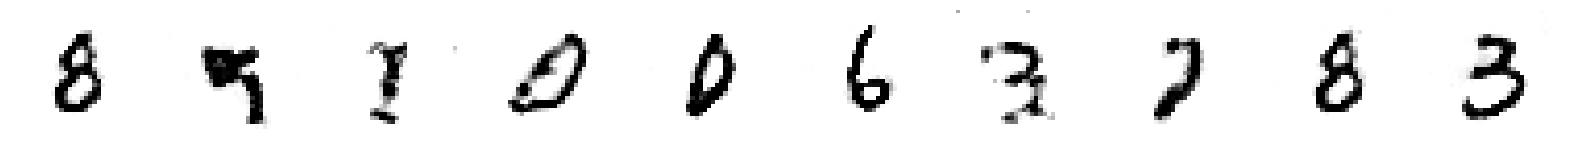

469/469 [==============================] - 1174s 3s/step - loss: 1.1092e-04 - reg: 1.0976e-04 - cdiv: 1.1583e-06 - real: 1.2095e-04 - fake: 1.2211e-04 - val_cdiv: -18.3275 - val_real: -0.0017 - val_fake: -18.3292
Epoch 50/60
469/469 [==============================] - ETA: 0s - loss: 7.6891e-05 - reg: 1.0678e-04 - cdiv: -2.9892e-05 - real: 2.3568e-04 - fake: 2.0579e-04
Saved to ./output/generated_img_049.png


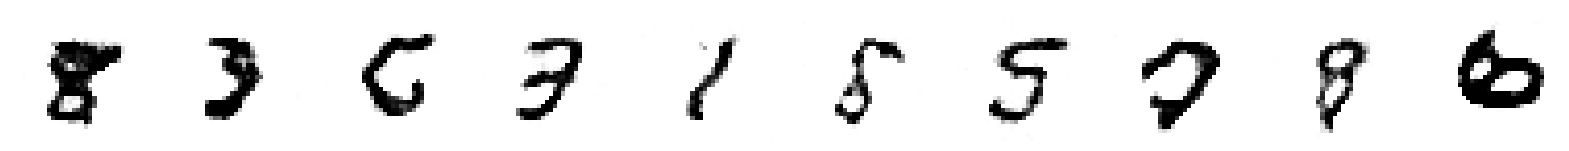


Saved to ./output/example_img_049.png


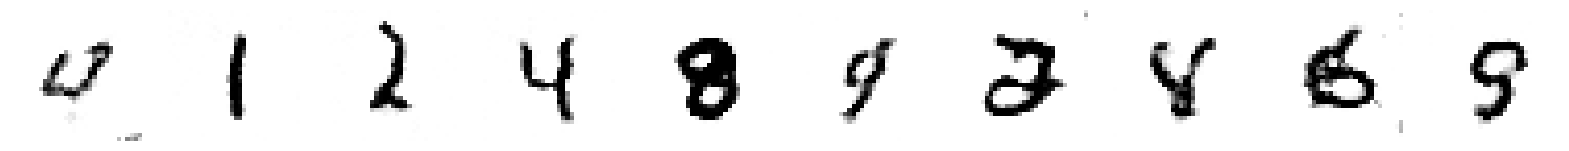

469/469 [==============================] - 1167s 2s/step - loss: 7.6891e-05 - reg: 1.0678e-04 - cdiv: -2.9892e-05 - real: 2.3568e-04 - fake: 2.0579e-04 - val_cdiv: -18.3611 - val_real: 3.0617e-04 - val_fake: -18.3608
Epoch 51/60
469/469 [==============================] - ETA: 0s - loss: 1.7594e-04 - reg: 1.2281e-04 - cdiv: 5.3124e-05 - real: 1.9190e-04 - fake: 2.4503e-04
Saved to ./output/generated_img_050.png


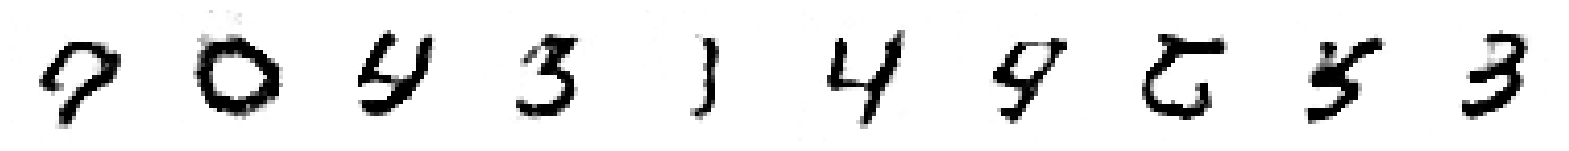


Saved to ./output/example_img_050.png


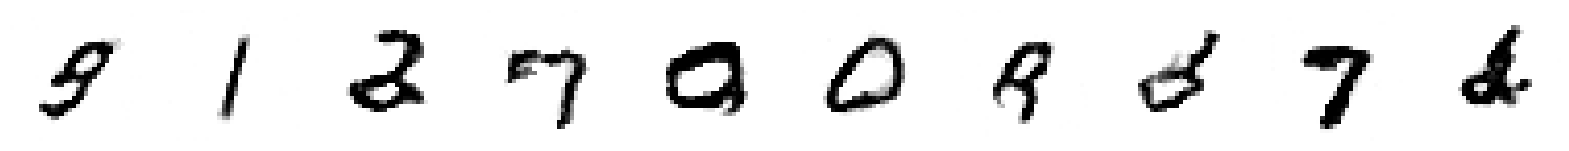

469/469 [==============================] - 1166s 2s/step - loss: 1.7594e-04 - reg: 1.2281e-04 - cdiv: 5.3124e-05 - real: 1.9190e-04 - fake: 2.4503e-04 - val_cdiv: -19.2249 - val_real: 0.0067 - val_fake: -19.2182
Epoch 52/60
469/469 [==============================] - ETA: 0s - loss: 1.7944e-04 - reg: 1.1141e-04 - cdiv: 6.8029e-05 - real: -4.6101e-05 - fake: 2.1928e-05
Saved to ./output/generated_img_051.png


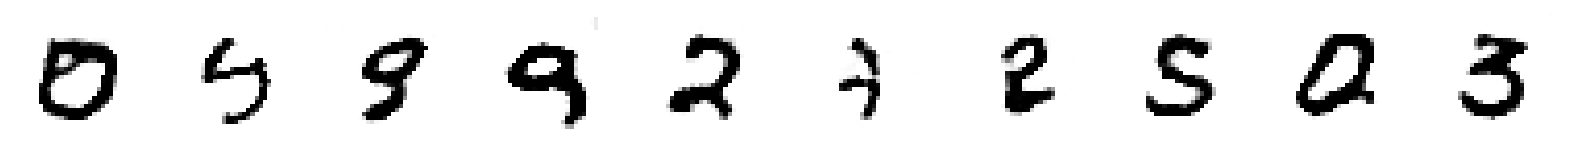


Saved to ./output/example_img_051.png


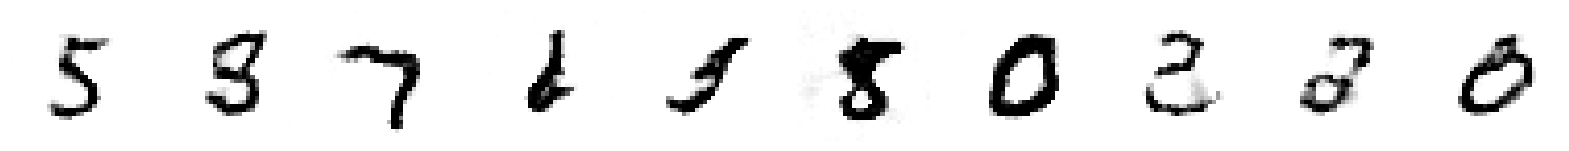

469/469 [==============================] - 1166s 2s/step - loss: 1.7944e-04 - reg: 1.1141e-04 - cdiv: 6.8029e-05 - real: -4.6101e-05 - fake: 2.1928e-05 - val_cdiv: -19.0114 - val_real: -0.0093 - val_fake: -19.0207
Epoch 53/60
469/469 [==============================] - ETA: 0s - loss: 1.6158e-04 - reg: 1.0731e-04 - cdiv: 5.4269e-05 - real: 2.2328e-05 - fake: 7.6597e-05
Saved to ./output/generated_img_052.png


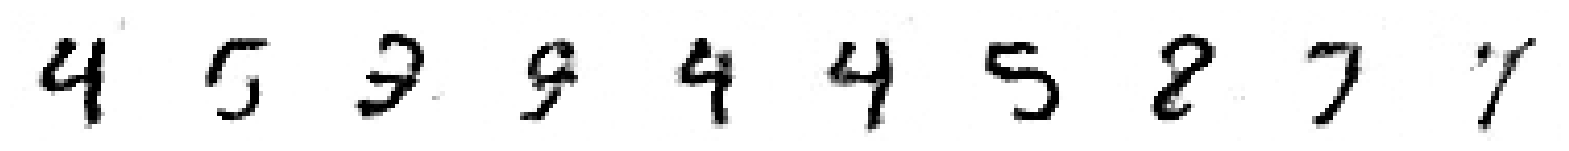


Saved to ./output/example_img_052.png


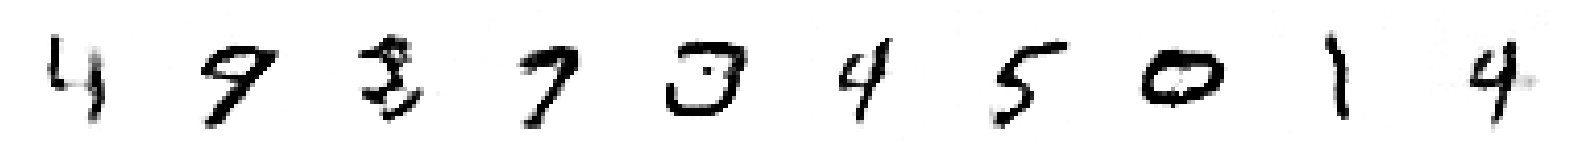

469/469 [==============================] - 1172s 2s/step - loss: 1.6158e-04 - reg: 1.0731e-04 - cdiv: 5.4269e-05 - real: 2.2328e-05 - fake: 7.6597e-05 - val_cdiv: -19.6414 - val_real: 0.0068 - val_fake: -19.6346
Epoch 54/60
469/469 [==============================] - ETA: 0s - loss: 4.8071e-05 - reg: 1.1831e-04 - cdiv: -7.0235e-05 - real: 4.5471e-04 - fake: 3.8448e-04
Saved to ./output/generated_img_053.png


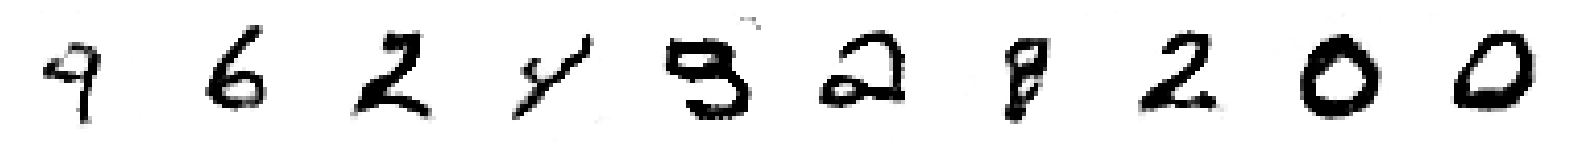


Saved to ./output/example_img_053.png


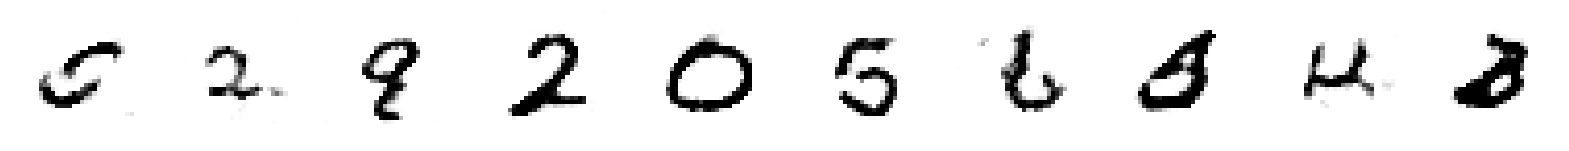

469/469 [==============================] - 1167s 2s/step - loss: 4.8071e-05 - reg: 1.1831e-04 - cdiv: -7.0235e-05 - real: 4.5471e-04 - fake: 3.8448e-04 - val_cdiv: -19.5316 - val_real: -0.0057 - val_fake: -19.5373
Epoch 55/60
469/469 [==============================] - ETA: 0s - loss: 2.7632e-04 - reg: 9.9881e-05 - cdiv: 1.7644e-04 - real: 1.1926e-04 - fake: 2.9570e-04
Saved to ./output/generated_img_054.png


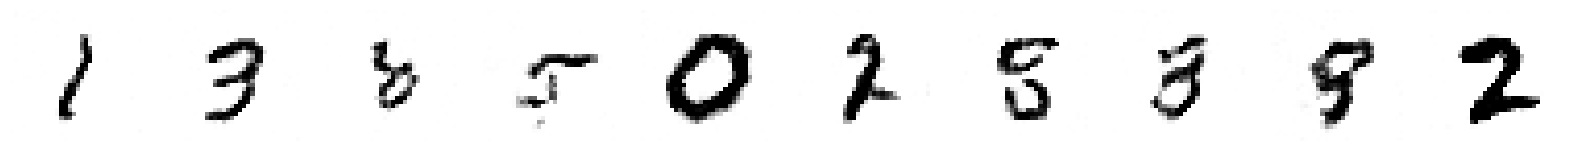


Saved to ./output/example_img_054.png


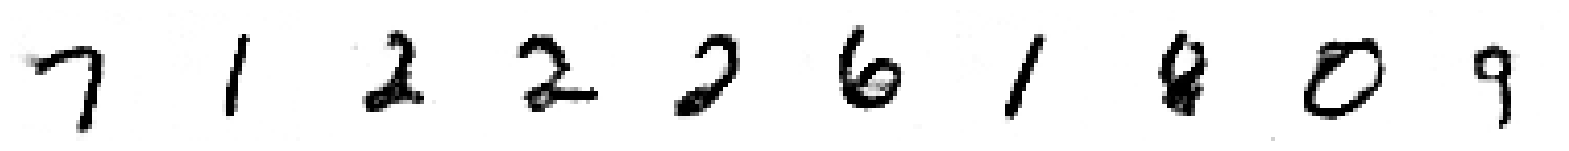

469/469 [==============================] - 1170s 2s/step - loss: 2.7632e-04 - reg: 9.9881e-05 - cdiv: 1.7644e-04 - real: 1.1926e-04 - fake: 2.9570e-04 - val_cdiv: -19.6401 - val_real: 0.0046 - val_fake: -19.6355
Epoch 56/60
469/469 [==============================] - ETA: 0s - loss: 3.3748e-09 - reg: 1.1144e-04 - cdiv: -1.1144e-04 - real: 7.7510e-05 - fake: -3.3927e-05 
Saved to ./output/generated_img_055.png


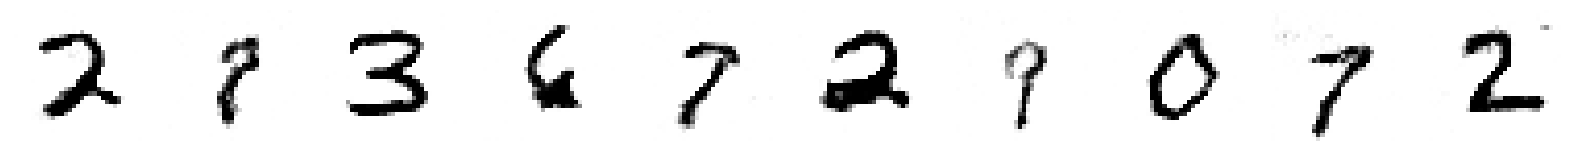


Saved to ./output/example_img_055.png


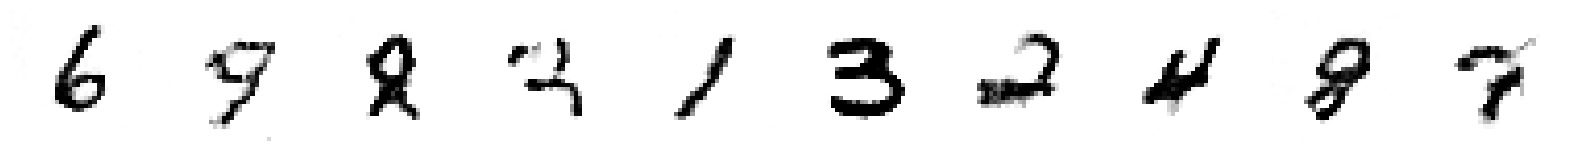

469/469 [==============================] - 1179s 3s/step - loss: 3.3748e-09 - reg: 1.1144e-04 - cdiv: -1.1144e-04 - real: 7.7510e-05 - fake: -3.3927e-05 - val_cdiv: -20.1601 - val_real: 0.0053 - val_fake: -20.1548
Epoch 57/60
469/469 [==============================] - ETA: 0s - loss: 2.2106e-04 - reg: 1.0540e-04 - cdiv: 1.1566e-04 - real: 2.8178e-04 - fake: 3.9744e-04
Saved to ./output/generated_img_056.png


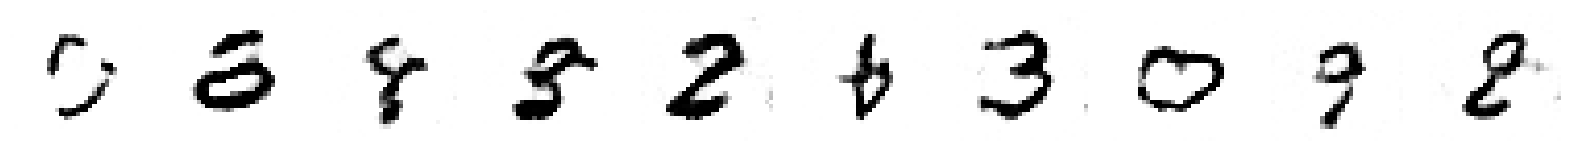


Saved to ./output/example_img_056.png


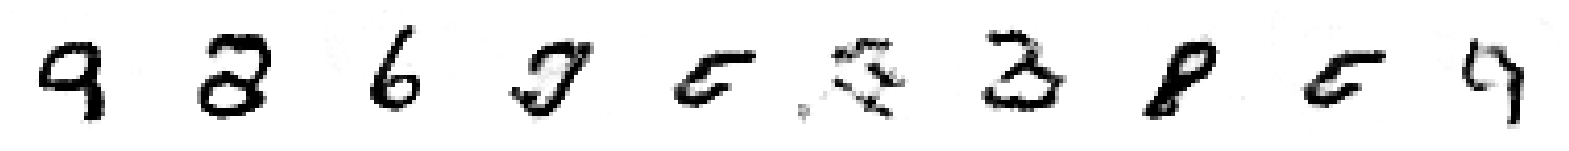

469/469 [==============================] - 1180s 3s/step - loss: 2.2106e-04 - reg: 1.0540e-04 - cdiv: 1.1566e-04 - real: 2.8178e-04 - fake: 3.9744e-04 - val_cdiv: -20.3423 - val_real: 0.0043 - val_fake: -20.3381
Epoch 58/60
469/469 [==============================] - ETA: 0s - loss: 1.4426e-04 - reg: 1.1139e-04 - cdiv: 3.2875e-05 - real: 1.6952e-04 - fake: 2.0239e-04
Saved to ./output/generated_img_057.png


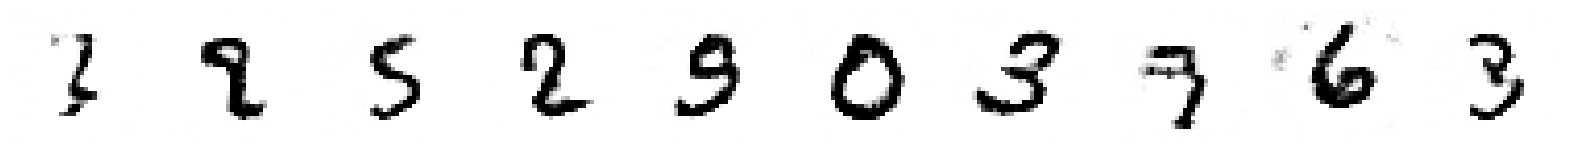


Saved to ./output/example_img_057.png


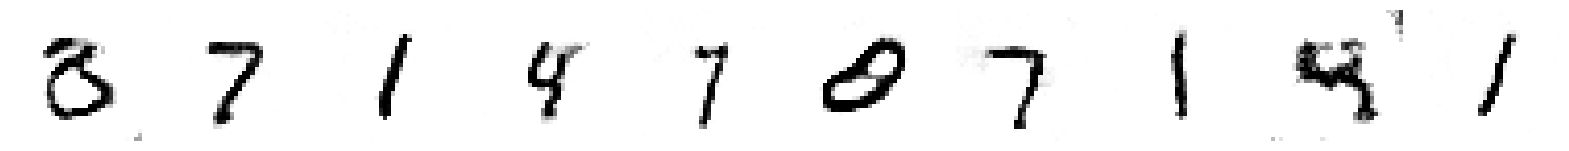

469/469 [==============================] - 1189s 3s/step - loss: 1.4426e-04 - reg: 1.1139e-04 - cdiv: 3.2875e-05 - real: 1.6952e-04 - fake: 2.0239e-04 - val_cdiv: -20.6097 - val_real: -9.2193e-04 - val_fake: -20.6106
Epoch 59/60
469/469 [==============================] - ETA: 0s - loss: 5.6211e-05 - reg: 1.1852e-04 - cdiv: -6.2304e-05 - real: 1.1966e-04 - fake: 5.7352e-05
Saved to ./output/generated_img_058.png


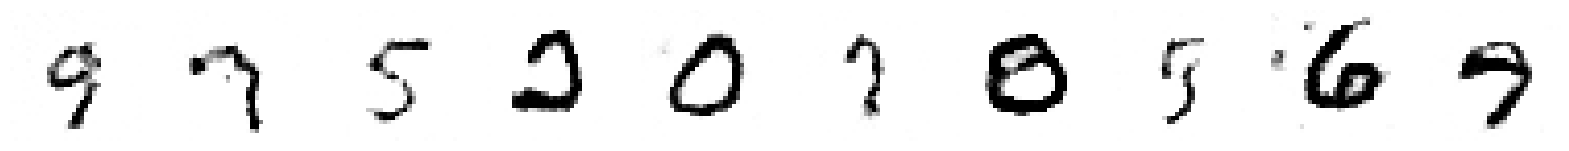


Saved to ./output/example_img_058.png


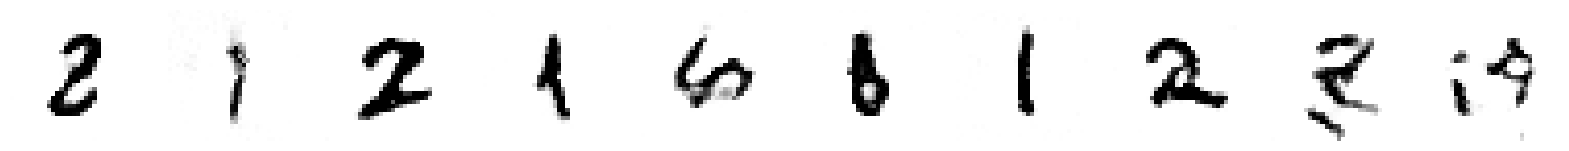

469/469 [==============================] - 1187s 3s/step - loss: 5.6211e-05 - reg: 1.1852e-04 - cdiv: -6.2304e-05 - real: 1.1966e-04 - fake: 5.7352e-05 - val_cdiv: -20.7460 - val_real: 0.0023 - val_fake: -20.7436
Epoch 60/60
469/469 [==============================] - ETA: 0s - loss: 1.0064e-04 - reg: 1.4908e-04 - cdiv: -4.8437e-05 - real: 7.3008e-05 - fake: 2.4571e-05
Saved to ./output/generated_img_059.png


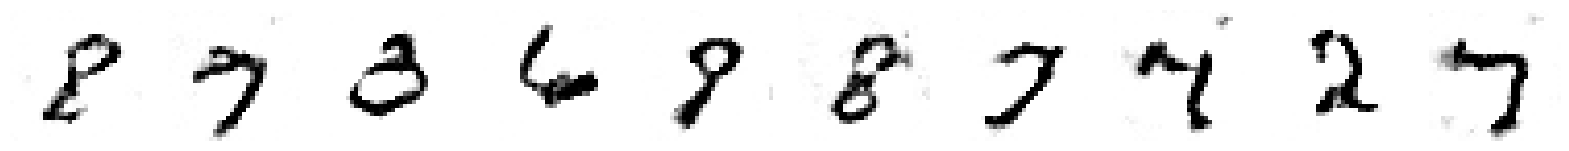


Saved to ./output/example_img_059.png


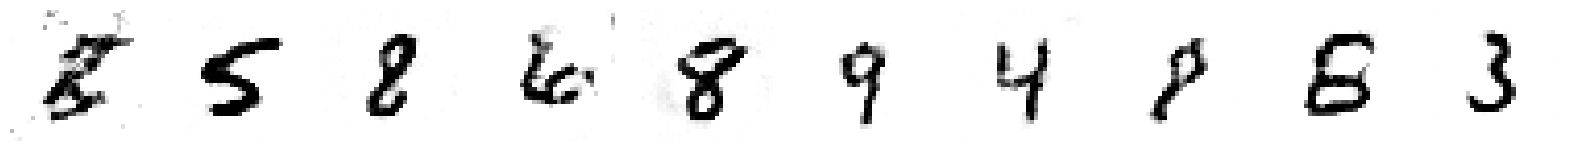

469/469 [==============================] - 1172s 2s/step - loss: 1.0064e-04 - reg: 1.4908e-04 - cdiv: -4.8437e-05 - real: 7.3008e-05 - fake: 2.4571e-05 - val_cdiv: -20.8911 - val_real: 0.0063 - val_fake: -20.8848


In [21]:
ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

## 4. Generate images <a name="generate"></a>

In [ ]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

In [ ]:
display(start_imgs)

In [ ]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

In [ ]:
display(gen_img[-1].numpy())

In [ ]:
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))